#### Author: Amit Vajpeyee
### Image to Caption Generation - December 2021
### Selenium Automation - December 2022

In [1]:
!python Flickr8k.py

Files - Flickr8k_text unzipped successfully in the working directory!
Checked attempt #1
Checked attempt #2
Checked attempt #3
Checked attempt #4
Checked attempt #5
Checked attempt #6
Checked attempt #7
Checked attempt #8
Checked attempt #9
Checked attempt #10
Checked attempt #11
Checked attempt #12
Checked attempt #13
Checked attempt #14
Checked attempt #15
Checked attempt #16
Checked attempt #17
File Found
Files - Flickr8k_Dataset unzipped successfully in the working directory!


C:\Users\Amit\Documents\Academics\NCI\Semester_3\Flickr8k.py:29: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r'C:\Users\Amit\Documents\Academics\NCI\Semester_3\chromedriver.exe')


In [2]:
# Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import keras
import glob
import random as rn 
from PIL import Image

import tensorflow as tf
rn.seed(42)
tf.random.set_seed(42)
from  tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import GRU, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, \
                                    concatenate, Dropout, BatchNormalization, Conv2D
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

from collections import Counter
import string
import imageio
import json
from tqdm import tqdm
import time
from gtts import gTTS
import os
from IPython.display import display, Audio

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the images into a seperate variable:

images = 'Research_project//Flicker8k_Dataset'

# glob (short for global) is used to return all file paths that match a specific pattern.
# Asterisk (*): Matches zero or more characters
# Question Mark (?) Matches exactly one character
# Source: https://towardsdatascience.com/the-python-glob-module-47d82f4cbd2d#:~:text=glob%20(short%20for%20global)%20is,
# pattern%20by%20using%20wildcard%20characters.
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [4]:
# Reading the text file into a seperate variable:

text = 'captions.txt'
text_df = pd.read_csv(text)
text_df.head(11)

image  \
0   1000268201_693b08cb0e.jpg   
1   1000268201_693b08cb0e.jpg   
2   1000268201_693b08cb0e.jpg   
3   1000268201_693b08cb0e.jpg   
4   1000268201_693b08cb0e.jpg   
5   1001773457_577c3a7d70.jpg   
6   1001773457_577c3a7d70.jpg   
7   1001773457_577c3a7d70.jpg   
8   1001773457_577c3a7d70.jpg   
9   1001773457_577c3a7d70.jpg   
10  1002674143_1b742ab4b8.jpg   

                                                                                         caption  
0                       A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                                          A girl going into a wooden building .  
2                                               A little girl climbing into a wooden playhouse .  
3                                           A little girl climbing the stairs to her playhouse .  
4                                      A little girl in a pink dress going into a wooden cabin .  
5                                                     A black dog and a spotted dog are fighting  
6                        A black dog and a tri-colored dog playing with each other on the road .  
7         A black dog and a white dog with brown spots are staring at each other in the street .  
8                               Two dogs of different breeds looking at each other on the road .  
9                                                Two dogs on pavement moving toward each other .  
10  A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .

In [5]:
# As we know, each individual image has 5 captions. This is further corroborated from the data from 'text_df' above

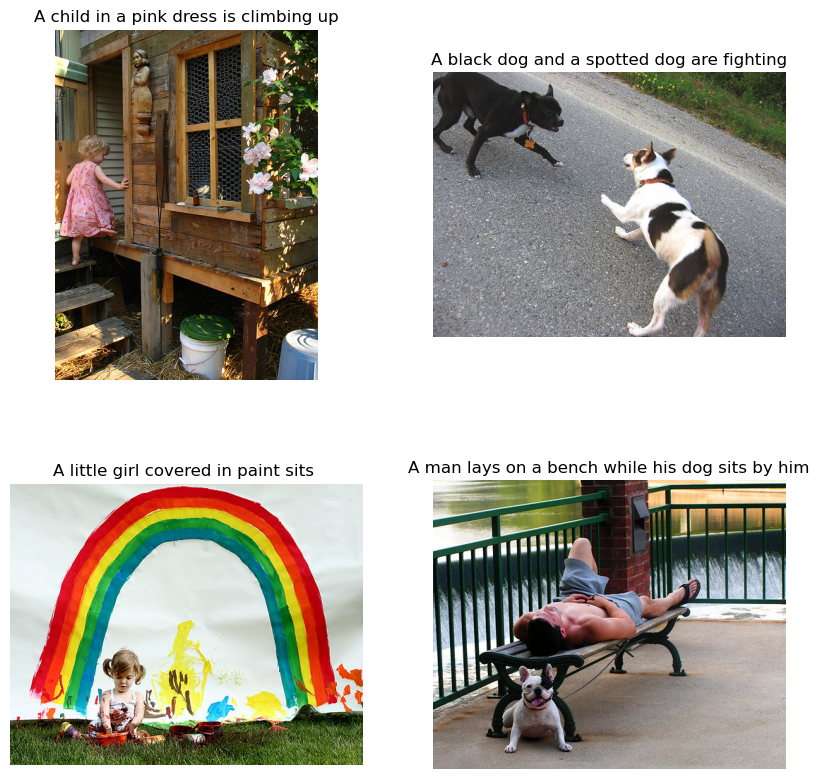

In [6]:
# Visualise both the images & text present in the dataset

# Visualizing the first 4 images and their respective first captions:

Image_0 = imageio.imread(all_imgs[0])
Image_1 = imageio.imread(all_imgs[1])
Image_2 = imageio.imread(all_imgs[2])
Image_3 = imageio.imread(all_imgs[3])

fig = plt.figure(figsize=(10, 10))

# Adding a subplot at the 1st position
fig.add_subplot(2, 2, 1)
plt.imshow(Image_0)
plt.axis('off')
plt.title(text_df.iat[0,1][:38])
  
# Adding a subplot at the 2nd position
fig.add_subplot(2, 2, 2)
plt.imshow(Image_1)
plt.axis('off')
plt.title(text_df.iat[5,1][:50])
  
# Adds a subplot at the 3rd position
fig.add_subplot(2, 2, 3)
plt.imshow(Image_2)
plt.axis('off')
plt.title(text_df.iat[10,1][:36])
  
# Adds a subplot at the 4th position
fig.add_subplot(2, 2, 4)
plt.imshow(Image_3)
plt.axis('off')
plt.title(text_df.iat[15,1][:47])

plt.show()

# I have capped the captions at varying lengths to avoid them getting jumbled up with the ones in the adjacent image.

In [7]:
# Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    text = open(filename).read()
    
    return text

text_file = "captions.txt"

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
all_img_id = text_df['image'].values #store all the image id here
all_img_vector = (images + '/' + text_df['image']).values #store all the image path here
annotations = text_df['caption'].values #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector, annotations)),columns =['ID','Path', 'Captions']) 
    
df.head(11)

ID  \
0   1000268201_693b08cb0e.jpg   
1   1000268201_693b08cb0e.jpg   
2   1000268201_693b08cb0e.jpg   
3   1000268201_693b08cb0e.jpg   
4   1000268201_693b08cb0e.jpg   
5   1001773457_577c3a7d70.jpg   
6   1001773457_577c3a7d70.jpg   
7   1001773457_577c3a7d70.jpg   
8   1001773457_577c3a7d70.jpg   
9   1001773457_577c3a7d70.jpg   
10  1002674143_1b742ab4b8.jpg   

                                                             Path  \
0   Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg   
1   Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg   
2   Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg   
3   Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg   
4   Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg   
5   Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg   
6   Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg   
7   Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg   
8   Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg   
9   Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg   
10  Research_project//Flicker8k_Dataset/1002674143_1b742ab4b8.jpg   

                                                                                        Captions  
0                       A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                                          A girl going into a wooden building .  
2                                               A little girl climbing into a wooden playhouse .  
3                                           A little girl climbing the stairs to her playhouse .  
4                                      A little girl in a pink dress going into a wooden cabin .  
5                                                     A black dog and a spotted dog are fighting  
6                        A black dog and a tri-colored dog playing with each other on the road .  
7         A black dog and a white dog with brown spots are staring at each other in the street .  
8                               Two dogs of different breeds looking at each other on the road .  
9                                                Two dogs on pavement moving toward each other .  
10  A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .

In [9]:
# Checking the shape of the data frame 'df':
df.shape

(40455, 3)

In [10]:
#Create a list which contains all the captions
annotations=df.Captions.apply(lambda x:"<start>" + " " + x + " " + "<end>")

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path =df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [11]:
#Create the vocabulary & the counter for the captions

# I am clubbing the capital and small lettered words together as they mean the same thing:

vocabulary = [y.lower() for x in df['Captions'].values for y in x.split()]

val_count = Counter(vocabulary)
val_count

Counter({'a': 62986,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         '.': 36577,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
         'at': 

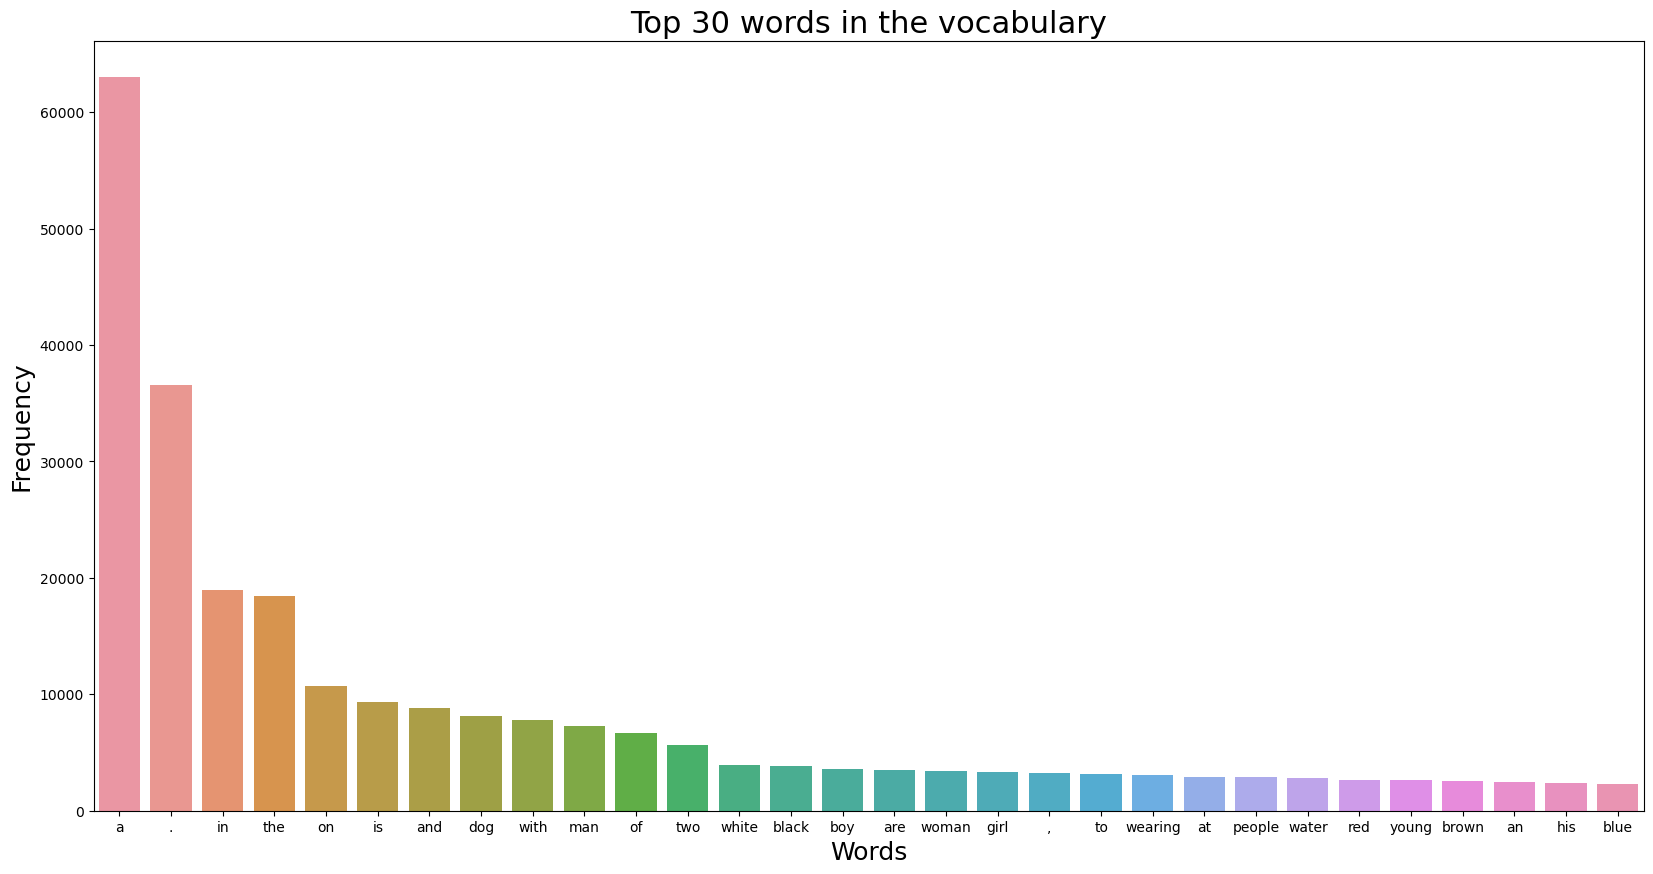

In [12]:
#Visualise the top 30 occuring words in the captions

top_30_words = val_count.most_common(30)

words = []
frequency = []

for word_count in top_30_words: 
    words.append(word_count[0])
    frequency.append(word_count[1])

plt.figure(figsize=(20,10))
plt.title('Top 30 words in the vocabulary', fontsize=22)
plt.xlabel('Words', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plot = sns.barplot(x = words, y = frequency)

plt.show()

In [13]:
# We can see that there are some punctuations. We need to remove all the punctuations and re-do this exercise:

In [14]:
# Removing all punctuation marks/ signs from the 'Captions' column in the data frame 'df': 
df['Captions'] = df['Captions'].apply(lambda x : ''.join(a for a in x if a not in string.punctuation))

# Creating the 'vocabulary' & the 'counter' again for the captions
vocabulary= [y.lower() for x in df['Captions'].values for y in x.split()] 

val_count = Counter(vocabulary)
val_count

Counter({'a': 62986,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tricolored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
         'at': 2914,
         'street

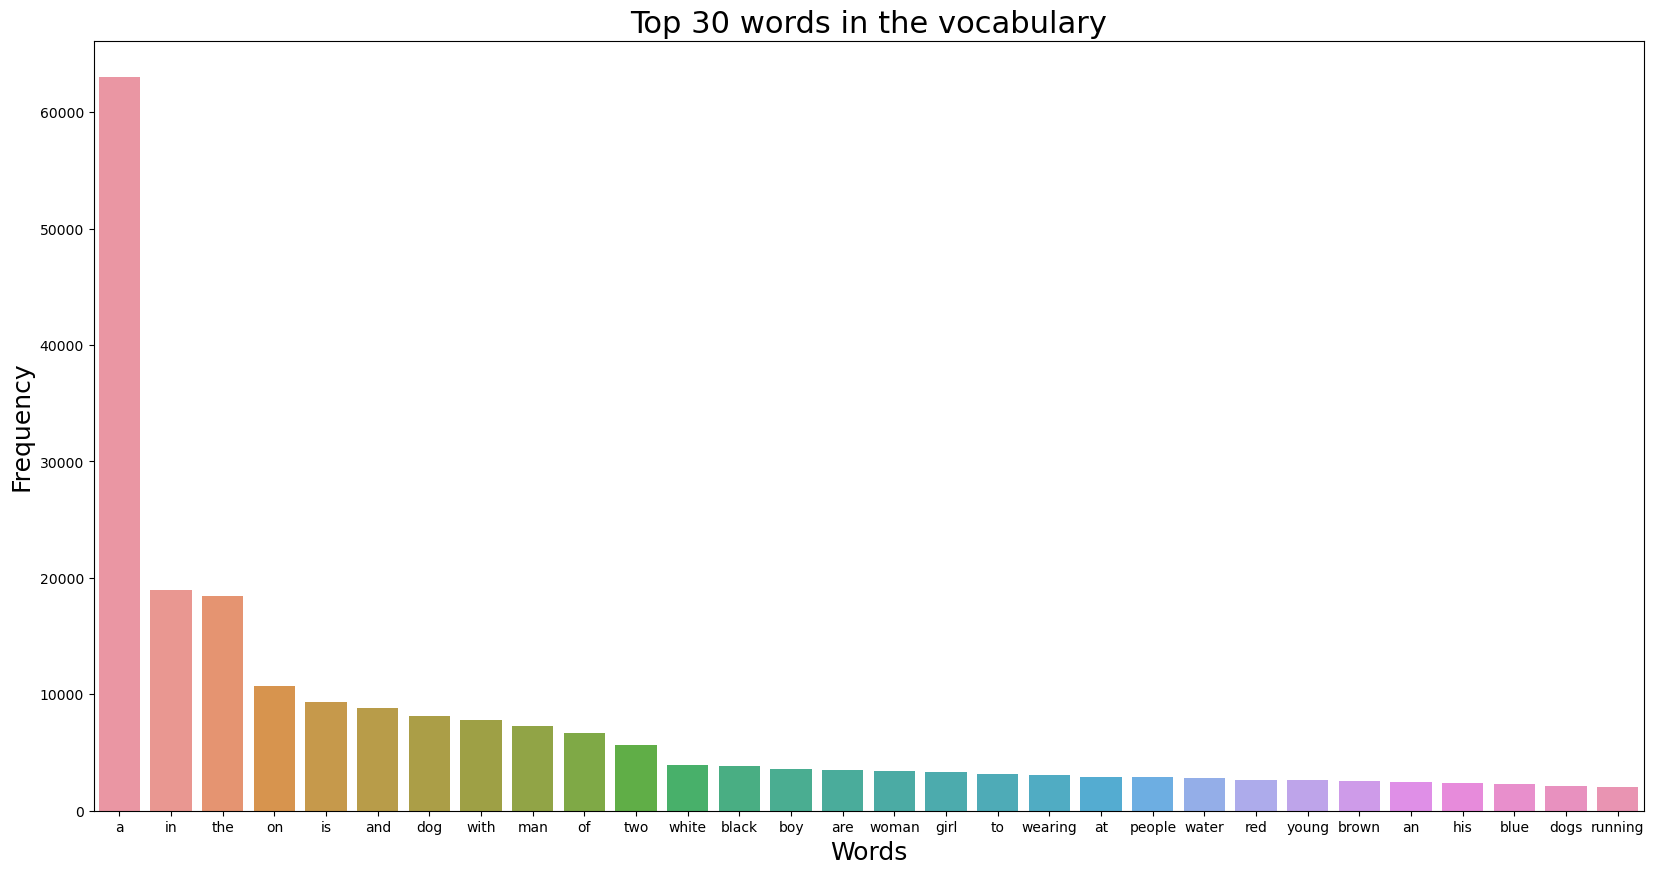

In [15]:
# Again visualising the top 30 occuring words in the captions 'vocabulary':

top_30_words = val_count.most_common(30)

words = []
frequency = []

for word_count in top_30_words: 
    words.append(word_count[0])
    frequency.append(word_count[1])

plt.figure(figsize=(20,10))
plt.title('Top 30 words in the vocabulary', fontsize=22)
plt.xlabel('Words', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plot = sns.barplot(x = words, y = frequency)

plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions for ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [16]:
# create the tokenizer

tokenizer = tf.keras.preprocessing.text.Tokenizer(
                num_words = 5000,
                filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                lower = True, split = ' ', char_level = False, oov_token = "<unk>"
               )
# Creating the internal vocabulary based on the captions that are there in the data
# set 'Flickr8K':
tokenizer.fit_on_texts(annotations)

# Transforming each text in the caption sequence to the sequence of integers, based
# on the internal vocab created just above:
tokenized_caption_seqs = tokenizer.texts_to_sequences(annotations)

In [17]:
len(tokenizer.word_index.keys())

8496

In [18]:
# Checking the length of the list 'tokenized_caption_seqs':
len(tokenized_caption_seqs)

40455

In [19]:
# Visualizing the first 5 lists in the list 'tokenized_caption_seqs':
tokenized_caption_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [20]:
# Doing one to one comparison by first viewing the first sentence in the annotations and then viewing the first list in
# the 'tokenized_captions_seqs':

# Viewing the first sentence in the annotations first:
annotations[0]

'<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>'

In [21]:
# Viewing the equivalent slist in the 'tokenized_captions_seqs':
tokenized_caption_seqs[0]

[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4]

In [22]:
# Creating word-to-index and index-to-word mappings:
word_to_index = tokenizer.word_index
index_to_word = dict(map(reversed, tokenizer.word_index.items()))

In [23]:
# Cross checking the mappings:
print('Index for the word:',"<unk> is", word_to_index["<unk>"])
print('Word for the index: 1 is ', index_to_word[1])

Index for the word: <unk> is 1
Word for the index: 1 is  <unk>


In [24]:
# Checking the dictionary 'word_to_index':
word_to_index

{'<unk>': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'in': 5,
 'the': 6,
 'on': 7,
 'is': 8,
 'and': 9,
 'dog': 10,
 'with': 11,
 'man': 12,
 'of': 13,
 'two': 14,
 'white': 15,
 'black': 16,
 'boy': 17,
 'are': 18,
 'woman': 19,
 'girl': 20,
 'to': 21,
 'wearing': 22,
 'at': 23,
 'people': 24,
 'water': 25,
 'red': 26,
 'young': 27,
 'brown': 28,
 'an': 29,
 'his': 30,
 'blue': 31,
 'dogs': 32,
 'running': 33,
 'through': 34,
 'playing': 35,
 'while': 36,
 'shirt': 37,
 'down': 38,
 'standing': 39,
 'ball': 40,
 'little': 41,
 'grass': 42,
 'snow': 43,
 'child': 44,
 'person': 45,
 'jumping': 46,
 'over': 47,
 'three': 48,
 'front': 49,
 'sitting': 50,
 'holding': 51,
 'up': 52,
 'field': 53,
 'small': 54,
 'by': 55,
 'large': 56,
 'green': 57,
 'one': 58,
 'group': 59,
 'yellow': 60,
 'her': 61,
 'walking': 62,
 'children': 63,
 'men': 64,
 'into': 65,
 'air': 66,
 'beach': 67,
 'near': 68,
 'mouth': 69,
 'jumps': 70,
 'another': 71,
 'for': 72,
 'street': 73,
 'runs': 74,
 'its': 75,


In [25]:
# Checking the dictionary 'index_to_word':
index_to_word

{1: '<unk>',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog',
 11: 'with',
 12: 'man',
 13: 'of',
 14: 'two',
 15: 'white',
 16: 'black',
 17: 'boy',
 18: 'are',
 19: 'woman',
 20: 'girl',
 21: 'to',
 22: 'wearing',
 23: 'at',
 24: 'people',
 25: 'water',
 26: 'red',
 27: 'young',
 28: 'brown',
 29: 'an',
 30: 'his',
 31: 'blue',
 32: 'dogs',
 33: 'running',
 34: 'through',
 35: 'playing',
 36: 'while',
 37: 'shirt',
 38: 'down',
 39: 'standing',
 40: 'ball',
 41: 'little',
 42: 'grass',
 43: 'snow',
 44: 'child',
 45: 'person',
 46: 'jumping',
 47: 'over',
 48: 'three',
 49: 'front',
 50: 'sitting',
 51: 'holding',
 52: 'up',
 53: 'field',
 54: 'small',
 55: 'by',
 56: 'large',
 57: 'green',
 58: 'one',
 59: 'group',
 60: 'yellow',
 61: 'her',
 62: 'walking',
 63: 'children',
 64: 'men',
 65: 'into',
 66: 'air',
 67: 'beach',
 68: 'near',
 69: 'mouth',
 70: 'jumps',
 71: 'another',
 72: 'for',
 73: 'street',
 74: 'runs',
 75: 'its',


In [26]:
# '0' is reserved for the padding. I will be adding this to the mappings later on.

In [27]:
# Checking the top 30 occuring words:

# Creating a dictionary 'word_counts' with individual words of captions as keys and corresponding numbers as values:

word_counts = tokenizer.get_config()['word_counts']
word_counts

'{"<start>": 40455, "a": 62992, "child": 1545, "in": 18986, "pink": 739, "dress": 348, "is": 9345, "climbing": 507, "up": 1302, "set": 109, "of": 6723, "stairs": 109, "an": 2432, "entry": 1, "way": 53, "<end>": 40455, "girl": 3328, "going": 149, "into": 1074, "wooden": 284, "building": 510, "little": 1768, "playhouse": 6, "the": 18419, "to": 3176, "her": 1178, "cabin": 4, "black": 3848, "dog": 8138, "and": 8862, "spotted": 38, "are": 3504, "fighting": 133, "tri": 14, "colored": 221, "playing": 2008, "with": 7765, "each": 430, "other": 773, "on": 10745, "road": 398, "white": 3959, "brown": 2578, "spots": 29, "staring": 57, "at": 2915, "street": 944, "two": 5642, "dogs": 2125, "different": 46, "breeds": 5, "looking": 743, "pavement": 48, "moving": 41, "toward": 146, "covered": 372, "paint": 62, "sits": 577, "front": 1386, "painted": 64, "rainbow": 22, "hands": 246, "bowl": 30, "sitting": 1368, "large": 1236, "small": 1278, "grass": 1622, "plays": 526, "fingerpaints": 3, "canvas": 6, "it"

In [28]:
# Converting the dictionary 'word_counts' in to pandas data frame for better visualization of word to number mapping:
word_counts_df = pd.DataFrame.from_dict(data = json.loads(word_counts), orient = 'index', columns = ['count'])
word_counts_df.head()

count
<start>  40455
a        62992
child     1545
in       18986
pink       739

In [29]:
# Checking the count of the words in descending order in the data frame 'words_count_df':

word_counts_df.sort_values(['count'], ascending = [False], inplace = True)
word_counts_df.head()

count
a        62992
<start>  40455
<end>    40455
in       18986
the      18419

In [30]:
# We can see '<start>' and '<end>' tokens in the data frame. These must be removed before finding the top 30 words:

word_counts_df.drop(['<start>', '<end>'], inplace = True)
word_counts_df.head()

count
a    62992
in   18986
the  18419
on   10745
is    9345

In [31]:
# Creating a new data frame 'top_30' containing the top 30 occuring words and their respective frequencies:
top_30 = word_counts_df.sort_values(by = 'count', ascending = False)[:30]
top_30.head()

count
a    62992
in   18986
the  18419
on   10745
is    9345

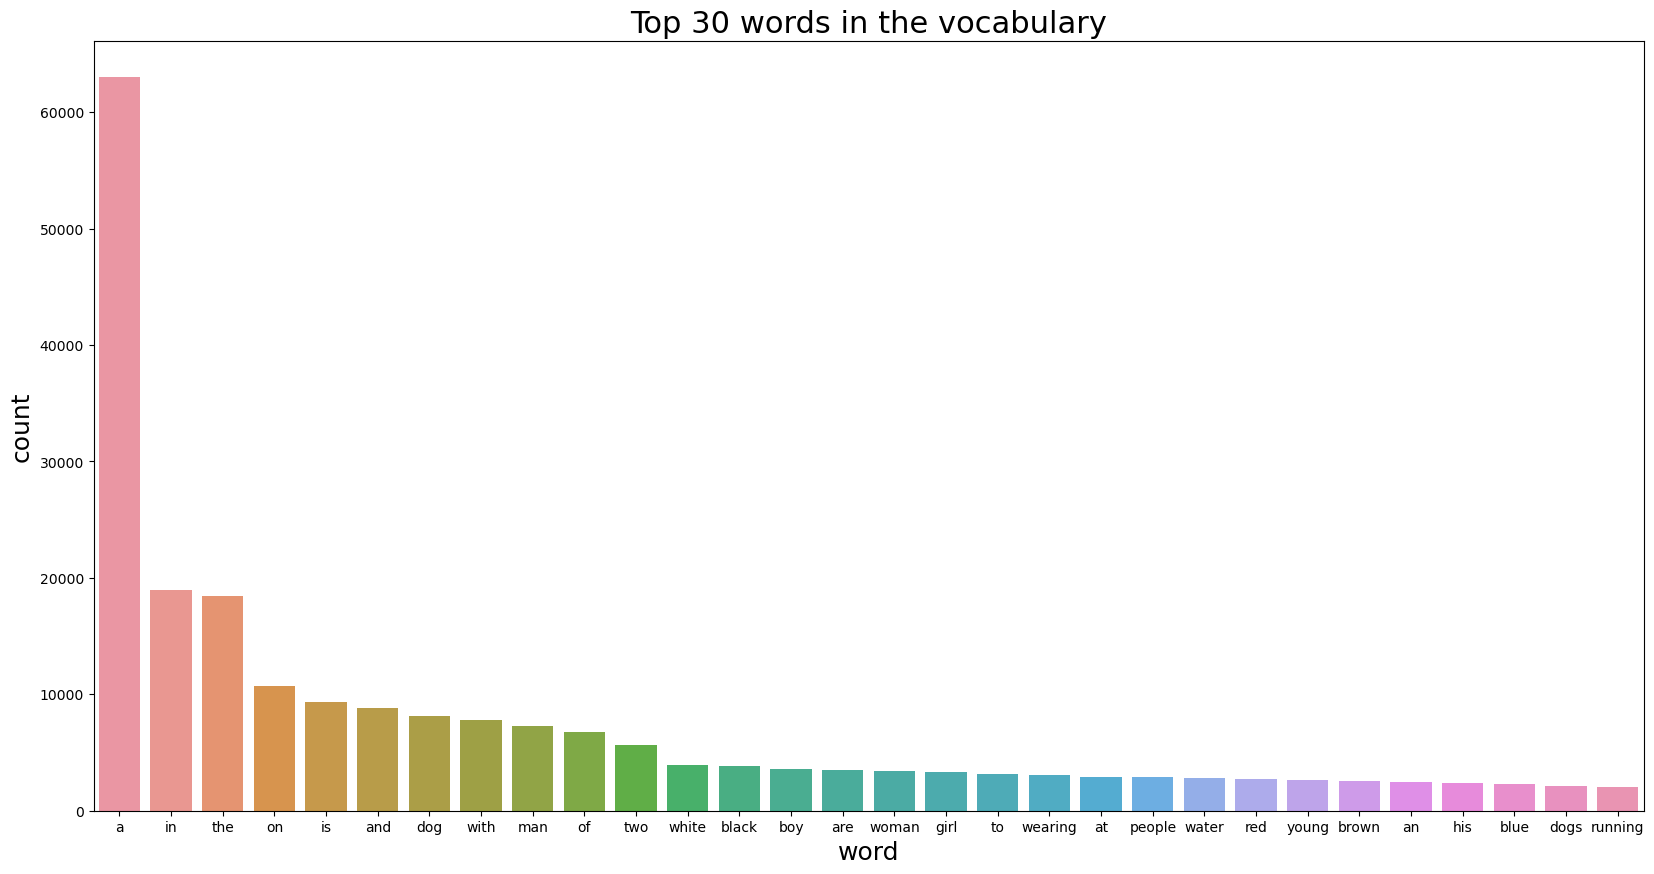

In [32]:
# Create a word count of my tokenizer to visulize the Top 30 occuring words after text processing

plt.figure(figsize = (20,10))
plt.title('Top 30 words in the vocabulary', fontsize = 22)
plt.xlabel('word', fontsize = 18)
plt.ylabel('count',  fontsize = 18)
plot = sns.barplot(x = top_30.index, y = top_30['count'])
plt.show()

In [33]:
# Pad each vector to the max_length of the captions ^ store it to a vairable:

max_len = max([len(tokenized_caption_seqs) for tokenized_caption_seqs in tokenized_caption_seqs])
max_len

39

In [34]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(tokenized_caption_seqs, padding="post", maxlen = max_len)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [35]:
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]])

In [36]:
# Adding padding index to tokenizer
tokenizer.word_index['<pad>'] = 0
index_to_word = dict(map(reversed, tokenizer.word_index.items()))

In [37]:
# Cross verifying the mappings for '<pad>':
print('Index for the word:',"<pad> is", word_to_index["<pad>"])
print('Word for the index: 0 is ', index_to_word[0])

Index for the word: <pad> is 0
Word for the index: 0 is  <pad>


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since I have a list which contains all the image path, I need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once I have created a dataset consisting of image paths, I need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [38]:
# Create the dataset consisting of image paths

In [39]:
# Typing the code here for creating the function.
# This function should return images & their path

def load_image(image_path):
    #pre-processing steps:
    
    # Read the image:
    given_img = tf.io.read_file(image_path)
    given_img = tf.image.decode_jpeg(given_img, channels = 3)
            
    # To resize the image in to the shape of (299, 299):
    # given_img = tf.keras.layers.Resizing(299, 299)(given_img)
    given_img = tf.image.resize(given_img, (299, 299))
    
    # To scale the input pixel values between -1 and 1/ To Normalize 
    # the image within the range of -1 to 1, such that it is
    # in correct format for InceptionV3:
    given_img = tf.keras.applications.inception_v3.preprocess_input(given_img) 
        
    return given_img, image_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


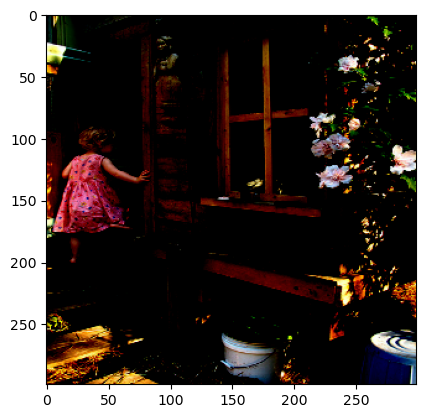

In [40]:
plt.imshow(load_image(all_imgs[0])[0])
# plt.axis('off')

In [41]:
# Checking the data type of the 'all_img_vector':
type(all_img_vector)

numpy.ndarray

In [42]:
# Viewing the contents of the numpy array 'all_img_vector':
all_img_vector

array(['Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
       'Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
       'Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
       ...,
       'Research_project//Flicker8k_Dataset/997722733_0cb5439472.jpg',
       'Research_project//Flicker8k_Dataset/997722733_0cb5439472.jpg',
       'Research_project//Flicker8k_Dataset/997722733_0cb5439472.jpg'],
      dtype=object)

In [43]:
all_img_vector[0]

'Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg'

In [44]:
type(all_img_vector[0])

str

In [45]:
# In order to apply 'tf.data.Dataset.from_tensor_slices' to the unique image paths, we need to convert 'all_img_vector'
# in to a list. Also, since each image has 5 captions, 'all_img_vector' contains multiple iterations of the same path,
# so, I would be applying 'set' on 'all_img_vector' to get the unique paths to the images.

In [46]:
# Getting paths of unique images and assigning them to the list 'encode_train_set':
encode_train_set = sorted(set(all_img_vector))
encode_train_set

['Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Research_project//Flicker8k_Dataset/1002674143_1b742ab4b8.jpg',
 'Research_project//Flicker8k_Dataset/1003163366_44323f5815.jpg',
 'Research_project//Flicker8k_Dataset/1007129816_e794419615.jpg',
 'Research_project//Flicker8k_Dataset/1007320043_627395c3d8.jpg',
 'Research_project//Flicker8k_Dataset/1009434119_febe49276a.jpg',
 'Research_project//Flicker8k_Dataset/1012212859_01547e3f17.jpg',
 'Research_project//Flicker8k_Dataset/1015118661_980735411b.jpg',
 'Research_project//Flicker8k_Dataset/1015584366_dfcec3c85a.jpg',
 'Research_project//Flicker8k_Dataset/101654506_8eb26cfb60.jpg',
 'Research_project//Flicker8k_Dataset/101669240_b2d3e7f17b.jpg',
 'Research_project//Flicker8k_Dataset/1016887272_03199f49c4.jpg',
 'Research_project//Flicker8k_Dataset/1019077836_6fc9b15408.jpg',
 'Research_project//Flicker8k_Dataset/1019604187_d087bf9a5f.jpg',
 'Research_p

In [47]:
# Checking the data type of 'encode_train_set':
type(encode_train_set)

list

In [48]:
len(encode_train_set)

8091

In [49]:
encode_train_set[0]

'Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg'

In [50]:
type(encode_train_set[0])

str

In [51]:
# Now that I have converted the numpy array 'all_img_vector' in to the list which has all the image paths: 'encode_train_set',
# I can apply 'tf.data.Dataset.from_tensor_slice' on the same (that is, on the list 'encode_train_set').

In [52]:
# Applying the function to the image path dataset, such that the transformed dataset should contain 
# images & their path

# Creating the TensorSliceDataset:
image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)

In [53]:
image_data_set

<TensorSliceDataset shapes: (), types: tf.string>

In [54]:
# Creating the BatchDataset from TensorSliceDataset:
image_data_set = image_data_set.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(64,
                                                                                                          drop_remainder=False)

In [55]:
image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [56]:
for image, image_path in image_data_set:
    print(image)

tf.Tensor(
[[[[-5.45791984e-01 -5.10859132e-01 -3.74351859e-01]
   [-1.49216354e-01 -1.96754932e-04 -3.11067104e-02]
   [-9.71772671e-02  4.68584299e-02  4.30215597e-02]
   ...
   [-9.72242475e-01 -9.68199551e-01 -9.81918097e-01]
   [-9.60785747e-01 -9.40206230e-01 -9.73770201e-01]
   [-9.62120771e-01 -9.38468575e-01 -9.81951475e-01]]

  [[-5.76532602e-01 -5.36172330e-01 -4.28583741e-01]
   [-1.48063362e-01  5.80894947e-03 -5.57081699e-02]
   [-7.81582594e-02  6.08934164e-02  7.88463354e-02]
   ...
   [-9.64205205e-01 -9.56362069e-01 -9.85233903e-01]
   [-9.39273238e-01 -9.26455736e-01 -9.55953360e-01]
   [-9.91893470e-01 -9.68992472e-01 -9.79893148e-01]]

  [[-5.92735231e-01 -5.68666816e-01 -4.35283601e-01]
   [-1.33154333e-01  5.47146797e-03 -1.36911869e-02]
   [-8.01610947e-02  5.69446087e-02  1.04957461e-01]
   ...
   [-9.52494144e-01 -9.27637577e-01 -9.50316966e-01]
   [-9.38245952e-01 -8.60414922e-01 -9.83451128e-01]
   [-8.28686595e-01 -6.75410032e-01 -9.57861304e-01]]

  ...

 

tf.Tensor(
[[[[ 0.4123757   0.28087854 -0.12742364]
   [ 0.41687655  0.26309216 -0.13776034]
   [ 0.43078375  0.25596333 -0.1371116 ]
   ...
   [ 0.24263859  0.1646663  -0.31284708]
   [ 0.18269336  0.08962083 -0.38056993]
   [ 0.23822892  0.11614239 -0.3458389 ]]

  [[ 0.3779286   0.27872217 -0.13834125]
   [ 0.36914825  0.26980257 -0.14721829]
   [ 0.432999    0.3171487  -0.09482592]
   ...
   [ 0.20647264  0.14139295 -0.3172207 ]
   [ 0.04630303 -0.02792013 -0.48516816]
   [ 0.17341483  0.06689286 -0.37775624]]

  [[ 0.33060658  0.23285604 -0.18608296]
   [ 0.2868253   0.19609153 -0.22520822]
   [ 0.26715744  0.19510305 -0.2355364 ]
   ...
   [ 0.21968794  0.18652892 -0.25112462]
   [ 0.17608309  0.13049269 -0.30094522]
   [ 0.15223265  0.06693017 -0.35325664]]

  ...

  [[ 0.06507075  0.1143204  -0.4058079 ]
   [ 0.0600301   0.06858766 -0.4277131 ]
   [ 0.32189882  0.2987566  -0.1858272 ]
   ...
   [-0.0208326   0.03933275 -0.4383241 ]
   [ 0.13885212  0.18170047 -0.29022527]
   [ 

tf.Tensor(
[[[[ 0.7888888   0.802634    0.8381249 ]
   [ 0.81529295  0.80468893  0.8445473 ]
   [ 0.77276385  0.8033949   0.8261181 ]
   ...
   [-0.87526995 -0.863541   -0.8584981 ]
   [-0.19975173 -0.19975173 -0.18561304]
   [ 0.36695123  0.3731923   0.3865571 ]]

  [[ 0.8017509   0.79551446  0.83663833]
   [ 0.8390304   0.809397    0.85398376]
   [ 0.78178763  0.7985835   0.8140389 ]
   ...
   [-0.09121072 -0.07775903 -0.05336523]
   [ 0.49660134  0.4989035   0.48735428]
   [ 0.7505839   0.76627016  0.7491412 ]]

  [[ 0.74138844  0.8194332   0.8325882 ]
   [ 0.8001889   0.8000848   0.83526695]
   [ 0.80911684  0.8038502   0.8221698 ]
   ...
   [ 0.5298008   0.5309652   0.5732775 ]
   [ 0.78198195  0.7936288   0.7545124 ]
   [ 0.86906636  0.88732135  0.8429681 ]]

  ...

  [[ 0.60784805  0.6183274   0.53437054]
   [ 0.6079725   0.6236912   0.58428144]
   [ 0.63136244  0.6455798   0.5697684 ]
   ...
   [ 0.6783936   0.69548595  0.7109728 ]
   [ 0.67480326  0.6823641   0.7058935 ]
   [ 

tf.Tensor(
[[[[ 7.20247626e-01  6.91513181e-01  7.24796772e-01]
   [ 4.31421280e-01  2.03012586e-01  1.69232607e-01]
   [ 4.41378117e-01  1.29912496e-01  3.52587700e-02]
   ...
   [-6.59077764e-02 -3.62848639e-01 -4.27436233e-01]
   [ 3.24758410e-01  5.43245077e-02 -1.76126957e-02]
   [ 4.54170465e-01  9.86343622e-02  7.08460808e-04]]

  [[ 7.12239623e-01  6.56623840e-01  7.16781259e-01]
   [ 5.25510669e-01  3.00188303e-01  2.32249260e-01]
   [ 4.86372471e-01  2.04246044e-01  4.96915579e-02]
   ...
   [ 1.68447018e-01 -2.68378854e-01 -2.97928452e-01]
   [ 4.86483574e-01  1.50088072e-01  6.11144304e-02]
   [ 5.23381233e-01  1.64848208e-01  8.90527964e-02]]

  [[ 6.55846357e-01  6.63835645e-01  7.12589979e-01]
   [ 5.47161341e-01  3.39162827e-01  2.60551929e-01]
   [ 4.84379172e-01  2.15535402e-01  4.75349426e-02]
   ...
   [ 3.37418199e-01 -2.33247638e-01 -1.75794959e-01]
   [ 5.56158900e-01  1.84844494e-01  1.30812287e-01]
   [ 5.95214605e-01  2.35244393e-01  1.61697149e-01]]

  ...

 

tf.Tensor(
[[[[-0.49250442 -0.36984718 -0.529215  ]
   [-0.32627714 -0.318434   -0.4593482 ]
   [-0.46231228 -0.45980722 -0.6229917 ]
   ...
   [-0.28660172 -0.18681902 -0.18932438]
   [-0.23947704 -0.16104567 -0.15333325]
   [-0.3563438  -0.26486218 -0.33789182]]

  [[-0.51486385 -0.42887664 -0.60589534]
   [-0.3998636  -0.37003082 -0.57654417]
   [-0.48114645 -0.4461869  -0.6524756 ]
   ...
   [-0.33236504 -0.24998635 -0.2424587 ]
   [-0.23192185 -0.16817099 -0.15314901]
   [-0.3196109  -0.26498407 -0.3134845 ]]

  [[-0.51641417 -0.4679979  -0.70467365]
   [-0.4111616  -0.3587516  -0.59810483]
   [-0.48578668 -0.43718445 -0.66622293]
   ...
   [-0.23582    -0.18905497 -0.17098582]
   [-0.27383387 -0.16868621 -0.16730839]
   [-0.33623004 -0.24162686 -0.29792535]]

  ...

  [[ 0.51859975  0.5264429   0.4019978 ]
   [ 0.5489141   0.5567572   0.43126702]
   [ 0.53902054  0.5468637   0.41069734]
   ...
   [-0.30723536 -0.2915491  -0.31350452]
   [-0.28831226 -0.28818154 -0.30235916]
   [-

tf.Tensor(
[[[[-0.67962086 -0.6784057  -0.74562097]
   [-0.66824114 -0.6904122  -0.76054764]
   [-0.6590744  -0.67032766 -0.745008  ]
   ...
   [-0.6368716  -0.6211853  -0.7178737 ]
   [-0.6660575  -0.6510532  -0.73528194]
   [-0.65679073 -0.6544036  -0.7171487 ]]

  [[-0.65576077 -0.6629219  -0.7389662 ]
   [-0.6464481  -0.6699775  -0.7405657 ]
   [-0.65933216 -0.6705854  -0.72957945]
   ...
   [-0.64703035 -0.63546765 -0.7093029 ]
   [-0.64620864 -0.63119864 -0.71544445]
   [-0.6447117  -0.64230466 -0.7051096 ]]

  [[-0.6618726  -0.66903377 -0.7450781 ]
   [-0.6646497  -0.68817914 -0.7490196 ]
   [-0.6508709  -0.6649091  -0.715548  ]
   ...
   [-0.6513078  -0.6434647  -0.69802535]
   [-0.6422713  -0.626585   -0.7128595 ]
   [-0.6691735  -0.6643993  -0.7343056 ]]

  ...

  [[-0.66503257 -0.7094767  -0.7423556 ]
   [-0.6579275  -0.69256824 -0.7414788 ]
   [-0.65497756 -0.6836127  -0.7409724 ]
   ...
   [-0.88588727 -0.870201   -0.8880654 ]
   [-0.8965394  -0.8808531  -0.8987175 ]
   [-

tf.Tensor(
[[[[-0.59964705 -0.56043136 -0.5344112 ]
   [-0.59252775 -0.55331206 -0.52180827]
   [-0.5851793  -0.54596364 -0.49890482]
   ...
   [ 0.16256225  0.18636823  0.24085534]
   [ 0.17597234  0.20036757  0.25397098]
   [ 0.16041636  0.18481147  0.23841488]]

  [[-0.5994849  -0.56156766 -0.53803825]
   [-0.60127676 -0.5646579  -0.5318775 ]
   [-0.5995853  -0.561199   -0.5163224 ]
   ...
   [ 0.15187609  0.1804161   0.22780216]
   [ 0.16856205  0.20777774  0.23915029]
   [ 0.15256965  0.19178534  0.22315788]]

  [[-0.63212013 -0.6007476  -0.5772182 ]
   [-0.61202204 -0.58849263 -0.54927695]
   [-0.59818614 -0.5639806  -0.53010297]
   ...
   [ 0.1637299   0.19226992  0.23965597]
   [ 0.16641605  0.20563173  0.23700428]
   [ 0.15037     0.18958569  0.22095823]]

  ...

  [[-0.5639127  -0.4606008  -0.24139959]
   [-0.55157197 -0.4496112  -0.19863075]
   [-0.5547641  -0.44212717 -0.19648486]
   ...
   [-0.4123429  -0.40053034 -0.38164753]
   [-0.40045375 -0.39461458 -0.37884498]
   [-

tf.Tensor(
[[[[-3.34245443e-01  1.08525753e-02  2.38303542e-01]
   [-3.17589819e-01  2.75081396e-02  2.54959226e-01]
   [-3.15460384e-01  2.96376944e-02  2.57088661e-01]
   ...
   [-1.08866632e-01  1.41116977e-01  3.05822849e-01]
   [-1.12663388e-01  1.37320280e-01  3.02026153e-01]
   [-1.25778973e-01  1.24204636e-01  2.88910508e-01]]

  [[-3.18883479e-01  2.62145996e-02  2.53665566e-01]
   [-3.17647040e-01  2.74510384e-02  2.54902005e-01]
   [-3.17647040e-01  2.74510384e-02  2.54902005e-01]
   ...
   [-8.46855044e-02  1.51391149e-01  3.18962574e-01]
   [-9.68708992e-02  1.43276095e-01  3.16953063e-01]
   [-1.09961510e-01  1.30185366e-01  3.03862333e-01]]

  [[-3.00797105e-01  2.93492079e-02  2.61784077e-01]
   [-3.02695215e-01  2.74510384e-02  2.59885907e-01]
   [-3.02695215e-01  2.74510384e-02  2.59885907e-01]
   ...
   [-6.33014441e-02  1.58133030e-01  3.27170849e-01]
   [-8.23113918e-02  1.43014789e-01  3.21282268e-01]
   [-9.04192924e-02  1.34907007e-01  3.13174367e-01]]

  ...

 

tf.Tensor(
[[[[-1.04978561e-01 -2.92479992e-03 -6.09902263e-01]
   [-1.18848920e-01  3.97872925e-03 -6.51185453e-01]
   [-1.60725892e-01  1.00895166e-02 -6.87724411e-01]
   ...
   [-1.10851407e-01  1.22071266e-01 -5.59517145e-01]
   [-1.30351543e-01  1.35187268e-01 -5.69698334e-01]
   [-1.04288697e-01  1.50835872e-01 -5.62535346e-01]]

  [[-1.42310381e-01 -8.01485777e-03 -6.44502521e-01]
   [-1.68089747e-01  9.06229019e-04 -6.84633851e-01]
   [-2.01330781e-01 -5.36191463e-03 -7.17537522e-01]
   ...
   [-1.10316277e-01  9.85060930e-02 -6.11494601e-01]
   [-1.46250904e-01  7.25725889e-02 -6.37428045e-01]
   [-9.19166803e-02  1.13552094e-01 -5.78299701e-01]]

  [[-1.85947239e-01 -1.07584000e-02 -6.91707969e-01]
   [-1.82427466e-01  1.59486532e-02 -6.89312696e-01]
   [-2.17486501e-01  4.77898121e-03 -7.07146287e-01]
   ...
   [-1.49990797e-01  7.63365030e-02 -6.61451042e-01]
   [-1.90753222e-01  8.21568966e-02 -6.47296369e-01]
   [-1.11895382e-01  1.44521952e-01 -5.55665672e-01]]

  ...

 

tf.Tensor(
[[[[ 9.77570415e-01  9.97213960e-01  9.76024628e-01]
   [ 9.98388648e-01  9.91956353e-01  9.98984456e-01]
   [ 9.64434385e-01  9.57808852e-01  9.79582667e-01]
   ...
   [ 2.39917397e-01  1.38516068e-01 -3.40778351e-01]
   [-2.83087492e-02 -9.84547734e-02 -5.62918544e-01]
   [-3.55932117e-02 -8.58188868e-02 -4.70473409e-01]]

  [[ 9.95177150e-01  9.95626926e-01  9.68177795e-01]
   [ 9.75978017e-01  9.91894484e-01  9.84302640e-01]
   [ 8.81760001e-01  9.49072719e-01  9.82850909e-01]
   ...
   [ 1.88825607e-01  1.09382629e-01 -3.99635732e-01]
   [-5.24841547e-02 -1.15294576e-01 -6.01765156e-01]
   [-6.97015524e-02 -1.35150731e-01 -5.20903468e-01]]

  [[ 9.92923141e-01  9.97770309e-01  9.67490077e-01]
   [ 9.80348587e-01  9.91931915e-01  9.82093096e-01]
   [ 8.40451360e-01  9.25574064e-01  9.62539196e-01]
   ...
   [ 1.29878402e-01  6.00023270e-02 -4.71152842e-01]
   [-3.38407755e-02 -9.66326594e-02 -5.83103180e-01]
   [ 3.25298309e-03 -8.81637931e-02 -4.67464983e-01]]

  ...

 

tf.Tensor(
[[[[-7.57486701e-01 -8.31904709e-01 -8.47145021e-01]
   [-9.86989319e-01 -9.92156863e-01 -1.00000000e+00]
   [-9.98519778e-01 -9.92906272e-01 -9.98519778e-01]
   ...
   [-4.54036772e-01 -2.98654199e-01 -2.43752241e-01]
   [-4.96291518e-01 -3.32923353e-01 -2.99669802e-01]
   [-5.38587213e-01 -3.81278515e-01 -3.72243822e-01]]

  [[-7.69918442e-01 -8.44336450e-01 -8.59576821e-01]
   [-9.86989319e-01 -9.92156863e-01 -1.00000000e+00]
   [-1.00000000e+00 -9.94386494e-01 -1.00000000e+00]
   ...
   [-3.84667575e-01 -2.82585323e-01 -2.12034345e-01]
   [-4.47782457e-01 -3.65163445e-01 -2.94629633e-01]
   [-5.54721355e-01 -4.83552337e-01 -4.27824140e-01]]

  [[-7.99692810e-01 -8.74110818e-01 -8.89351130e-01]
   [-9.86989319e-01 -9.92156863e-01 -1.00000000e+00]
   [-1.00000000e+00 -9.94386494e-01 -1.00000000e+00]
   ...
   [-4.62489128e-01 -3.31499696e-01 -2.74529338e-01]
   [-4.69142973e-01 -3.54257822e-01 -3.05278659e-01]
   [-5.41307569e-01 -4.53534245e-01 -4.16563153e-01]]

  ...

 

tf.Tensor(
[[[[-6.05252981e-02  3.53246093e-01 -7.44408488e-01]
   [-3.97357762e-01  9.27443504e-02 -9.57438529e-01]
   [-3.19447517e-02  2.16938496e-01 -6.13332391e-01]
   ...
   [-2.84531176e-01 -1.63351357e-01 -4.73699093e-01]
   [-9.14708376e-01 -8.73684764e-01 -7.99647987e-01]
   [-9.12389219e-01 -8.24509501e-01 -8.59966993e-01]]

  [[-2.62180388e-01 -5.07744551e-02 -6.98008180e-01]
   [-5.13501167e-02  2.32864618e-01 -5.43849587e-01]
   [ 3.12457085e-02  3.26197386e-01 -6.60471797e-01]
   ...
   [-9.78904188e-01 -8.79632235e-01 -8.92692566e-01]
   [-6.90107942e-01 -6.16079330e-01 -6.61852956e-01]
   [-6.14158154e-01 -4.01426554e-01 -7.08879232e-01]]

  [[-3.85050178e-02  1.31349325e-01 -5.44907808e-01]
   [-3.20515215e-01  1.75027847e-02 -8.95373762e-01]
   [-1.13165259e-01  1.09876990e-01 -6.37685418e-01]
   ...
   [-8.82985771e-01 -7.60978043e-01 -7.88457990e-01]
   [-6.00968003e-01 -4.34433103e-01 -6.13434672e-01]
   [-8.29329967e-01 -7.06879139e-01 -8.34832311e-01]]

  ...

 

tf.Tensor(
[[[[ 7.64351726e-01  8.68306160e-01  9.16361690e-01]
   [ 7.97998071e-01  8.86266112e-01  9.35301900e-01]
   [ 7.94111013e-01  8.83736014e-01  9.31473255e-01]
   ...
   [ 8.55199337e-01  9.35820699e-01  9.84691620e-01]
   [ 8.39118004e-01  9.54706192e-01  9.86022115e-01]
   [ 7.99021840e-01  9.34013724e-01  9.91794229e-01]]

  [[ 7.37806916e-01  8.57464194e-01  9.12366152e-01]
   [ 7.41885900e-01  8.55808139e-01  9.15481806e-01]
   [ 7.30279684e-01  8.50807548e-01  9.04159665e-01]
   ...
   [ 8.06819320e-01  9.34294224e-01  9.78942752e-01]
   [ 8.14826488e-01  9.16796803e-01  9.99875426e-01]
   [ 7.95920491e-01  9.37303662e-01  9.68183398e-01]]

  [[ 7.16459513e-01  8.45996499e-01  9.05882359e-01]
   [ 7.07571983e-01  8.50914836e-01  9.05816793e-01]
   [ 6.92906141e-01  8.41191292e-01  8.96093249e-01]
   ...
   [ 8.06137443e-01  9.08062816e-01  9.60138440e-01]
   [ 7.79730201e-01  8.96731973e-01  9.10668373e-01]
   [ 7.50911832e-01  8.64326954e-01  8.64106536e-01]]

  ...

 

tf.Tensor(
[[[[ 0.19707716 -0.02607006 -0.24938226]
   [ 0.12250519 -0.19146383 -0.5325446 ]
   [ 0.26557314  0.01125956 -0.25652742]
   ...
   [-0.35032237 -0.48824537 -0.5792372 ]
   [-0.5010524  -0.5792378  -0.6580609 ]
   [-0.7323029  -0.7726058  -0.8645333 ]]

  [[ 0.11898494 -0.02109766 -0.3425725 ]
   [ 0.02525353 -0.16720122 -0.42359567]
   [ 0.09098434 -0.0596208  -0.32719934]
   ...
   [-0.11550629 -0.4384892  -0.5229213 ]
   [-0.5660871  -0.63207513 -0.71978474]
   [-0.7629789  -0.7813408  -0.87843955]]

  [[ 0.03911436 -0.06860614 -0.29837465]
   [ 0.11727977 -0.00101894 -0.07524908]
   [-0.05933428 -0.13539165 -0.32311046]
   ...
   [-0.32652795 -0.47277403 -0.58800113]
   [-0.54800665 -0.61826634 -0.71677804]
   [-0.76020193 -0.7781966  -0.8659698 ]]

  ...

  [[ 0.01343703  0.34294057 -0.4749183 ]
   [ 0.09475303  0.32435572 -0.34372932]
   [ 0.00407207  0.2802837  -0.5393047 ]
   ...
   [ 0.02614915  0.24190605 -0.5180944 ]
   [ 0.04517913  0.3111093  -0.1650595 ]
   [-

tf.Tensor(
[[[[ 0.13566637  0.1435095   0.17488205]
   [ 0.1385665   0.14640963  0.17765093]
   [ 0.15905797  0.16690111  0.18258739]
   ...
   [-0.4934361  -0.23139715  0.08769071]
   [-0.49633396 -0.22241431  0.09013069]
   [-0.4990381  -0.23962438  0.08017361]]

  [[ 0.14832938  0.15617251  0.18754506]
   [ 0.15482807  0.16267121  0.19391263]
   [ 0.16983247  0.1776756   0.19336188]
   ...
   [-0.46926725 -0.23042089  0.08953524]
   [-0.476331   -0.21320558  0.08660424]
   [-0.48031205 -0.21718663  0.08262324]]

  [[ 0.14741957  0.15526271  0.18663526]
   [ 0.16084993  0.16869307  0.19993436]
   [ 0.17195714  0.17980027  0.19548655]
   ...
   [-0.4650184  -0.22402638  0.09586108]
   [-0.4823529  -0.23137254  0.07450986]
   [-0.4813611  -0.23038071  0.07550156]]

  ...

  [[-0.10225421  0.18794179  0.6160257 ]
   [-0.10286576  0.18733025  0.60891855]
   [-0.08975017  0.20044589  0.62869334]
   ...
   [-0.07845473  0.18788481  0.5903901 ]
   [-0.09799844  0.18435454  0.59219766]
   [-

In [57]:
for image, image_path in image_data_set:
    print(type(image_path[0]))
    break

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [58]:
for image, image_path in image_data_set:
    print(image_path)
    break

tf.Tensor(
[b'Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
 b'Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg'
 b'Research_project//Flicker8k_Dataset/1002674143_1b742ab4b8.jpg'
 b'Research_project//Flicker8k_Dataset/1003163366_44323f5815.jpg'
 b'Research_project//Flicker8k_Dataset/1007129816_e794419615.jpg'
 b'Research_project//Flicker8k_Dataset/1007320043_627395c3d8.jpg'
 b'Research_project//Flicker8k_Dataset/1009434119_febe49276a.jpg'
 b'Research_project//Flicker8k_Dataset/1012212859_01547e3f17.jpg'
 b'Research_project//Flicker8k_Dataset/1015118661_980735411b.jpg'
 b'Research_project//Flicker8k_Dataset/1015584366_dfcec3c85a.jpg'
 b'Research_project//Flicker8k_Dataset/101654506_8eb26cfb60.jpg'
 b'Research_project//Flicker8k_Dataset/101669240_b2d3e7f17b.jpg'
 b'Research_project//Flicker8k_Dataset/1016887272_03199f49c4.jpg'
 b'Research_project//Flicker8k_Dataset/1019077836_6fc9b15408.jpg'
 b'Research_project//Flicker8k_Dataset/1019604187_d087bf9a5f.jpg'
 

In [59]:
# We can see that the transformed dataset contains the images and their respective paths

In [60]:
for image, image_path in image_data_set:
    print(type(image_path[0]))
    break

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [61]:
for image, image_path in image_data_set:
    print(image_path[0])
    break

tf.Tensor(b'Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg', shape=(), dtype=string)


In [62]:
# Also, since the 'image_path' tensor in the BatchDataset "image_data_set" contains byte objects, I would be converting
# these in to numpy objects with the help of the command 'byte_object.numpy().decode("utf-8")' after few code blocks.

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [63]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input  
hidden_layer = image_model.layers[-1].output  

image_features_extract_model = keras.Model(new_input, hidden_layer) 

In [64]:
# Checking the model summary:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [65]:
# Creating an empty dictionary 'feature_and_caption_dict':

feature_and_caption_dict = {}

# Using the library 'tqdm' to see the progress bar:

for img, path in tqdm(image_data_set):
    # write the code to apply the feature_extraction model to my earlier created dataset which contained images & their
    # respective paths.
    batch_features = image_features_extract_model(img)
    # Once the features are created, I need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
        
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # np.save(path_of_feature, bf.numpy())
        feature_and_caption_dict[path_of_feature] = bf.numpy()

100%|██████████| 127/127 [00:31<00:00,  4.08it/s]


In [66]:
# We know that the total number of images in the 'Flickr8K' data set is 8,091 and the batch_size = 64.
# 8091/ 64 = 127 (Approximately)
# That is why we are seeing 127 iterations above.

In [67]:
# 64 * 126 = 8064
# 8091 - 8064 = 27
batch_features.shape

TensorShape([27, 64, 2048])

In [68]:
type(batch_features)

tensorflow.python.framework.ops.EagerTensor

In [69]:
bf.shape

TensorShape([64, 2048])

In [70]:
type(bf)

tensorflow.python.framework.ops.EagerTensor

In [71]:
# Viewing the dictionary 'feature_and_caption_dict':
feature_and_caption_dict

{'Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.1708493 ],
        [0.        , 0.        , 1.0111418 , ..., 0.        , 0.        ,
         0.06221141],
        ...,
        [0.        , 0.        , 2.0361905 , ..., 1.2083538 , 0.        ,
         1.9881415 ],
        [0.        , 0.        , 0.90308875, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.250996  , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 'Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg': array([[0.        , 0.6651477 , 0.46181595, ..., 0.        , 0.        ,
         3.3388588 ],
        [0.        , 1.2275842 , 0.        , ..., 0.        , 0.25399804,
         3.334624  ],
        [1.2881552 , 1.5149782 , 0.        , ..., 0.46732244, 0.3650907 

In [72]:
# Viewing the keys of the dictionary 'feature_and_caption_dict':
feature_and_caption_dict.keys()

dict_keys(['Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'Research_project//Flicker8k_Dataset/1002674143_1b742ab4b8.jpg', 'Research_project//Flicker8k_Dataset/1003163366_44323f5815.jpg', 'Research_project//Flicker8k_Dataset/1007129816_e794419615.jpg', 'Research_project//Flicker8k_Dataset/1007320043_627395c3d8.jpg', 'Research_project//Flicker8k_Dataset/1009434119_febe49276a.jpg', 'Research_project//Flicker8k_Dataset/1012212859_01547e3f17.jpg', 'Research_project//Flicker8k_Dataset/1015118661_980735411b.jpg', 'Research_project//Flicker8k_Dataset/1015584366_dfcec3c85a.jpg', 'Research_project//Flicker8k_Dataset/101654506_8eb26cfb60.jpg', 'Research_project//Flicker8k_Dataset/101669240_b2d3e7f17b.jpg', 'Research_project//Flicker8k_Dataset/1016887272_03199f49c4.jpg', 'Research_project//Flicker8k_Dataset/1019077836_6fc9b15408.jpg', 'Research_project//Flicker8k_Dataset/1019604187_d087bf9a5f.jpg', 'Research_projec

In [73]:
# Viewing the values of the dictionary 'feature_and_caption_dict':
feature_and_caption_dict[path_of_feature]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.1044517 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.2061919 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.5207952 ],
       ...,
       [0.        , 0.        , 0.33068737, ..., 0.        , 0.00879325,
        0.06404105],
       [0.        , 0.        , 0.25935796, ..., 0.        , 0.        ,
        0.4561283 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.35147434]], dtype=float32)

In [74]:
# Viewing the shape of the values of the dictionary 'feature_and_caption_dict':
feature_and_caption_dict[path_of_feature].shape

(64, 2048)

In [75]:
# Let us cross check by keeping the batch size to be 256. In this case, there should be 8091/ 256 = 32 iterations
# (approximately):

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set_new = image_data_set.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(256)

feature_and_caption_dict = {}

for img, path in tqdm(image_data_set_new):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
   

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # np.save(path_of_feature, bf.numpy())
        feature_and_caption_dict[path_of_feature] = bf.numpy()        

100%|██████████| 32/32 [00:31<00:00,  1.03it/s]


In [76]:
# For now, I would be going ahead with batch_size = 256 and the related values of 'path_to_feature' and 'batch_features'.

### FAQs on how to store the features:
* One can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* One can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure I have done shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
# Applying the train_test_split:

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector, train_size = 0.8, random_state = 42)

In [78]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [79]:
type(path_train)

numpy.ndarray

In [80]:
type(path_test)

numpy.ndarray

In [81]:
type(cap_train)

numpy.ndarray

In [82]:
type(cap_test)

numpy.ndarray

In [83]:
# Viewing the Tensor of image path from the BatchDataset 'image_data_set_new':
for image, image_path in image_data_set_new:
    print(image_path)
    break

tf.Tensor(
[b'Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
 b'Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg'
 b'Research_project//Flicker8k_Dataset/1002674143_1b742ab4b8.jpg'
 b'Research_project//Flicker8k_Dataset/1003163366_44323f5815.jpg'
 b'Research_project//Flicker8k_Dataset/1007129816_e794419615.jpg'
 b'Research_project//Flicker8k_Dataset/1007320043_627395c3d8.jpg'
 b'Research_project//Flicker8k_Dataset/1009434119_febe49276a.jpg'
 b'Research_project//Flicker8k_Dataset/1012212859_01547e3f17.jpg'
 b'Research_project//Flicker8k_Dataset/1015118661_980735411b.jpg'
 b'Research_project//Flicker8k_Dataset/1015584366_dfcec3c85a.jpg'
 b'Research_project//Flicker8k_Dataset/101654506_8eb26cfb60.jpg'
 b'Research_project//Flicker8k_Dataset/101669240_b2d3e7f17b.jpg'
 b'Research_project//Flicker8k_Dataset/1016887272_03199f49c4.jpg'
 b'Research_project//Flicker8k_Dataset/1019077836_6fc9b15408.jpg'
 b'Research_project//Flicker8k_Dataset/1019604187_d087bf9a5f.jpg'
 

In [84]:
# We can see 'b' in front of the image paths. In order to covert these byte strings into a numpy.string_, I would need to
# convert it with the help of decode('utf-8') command.

In [85]:
# Decoding a single batch in the tensor 'image_path' in the BatchDataset 'image_data_set_new':
for image, image_path in image_data_set_new:
    decoder = np.vectorize(lambda x: x.decode('UTF-8'))
    array2 = decoder(image_path)
    print(array2)
    print(array2.shape)
    print(type(array2))
    print(type(array2[0]))
    break

['Research_project//Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
 'Research_project//Flicker8k_Dataset/1001773457_577c3a7d70.jpg'
 'Research_project//Flicker8k_Dataset/1002674143_1b742ab4b8.jpg'
 'Research_project//Flicker8k_Dataset/1003163366_44323f5815.jpg'
 'Research_project//Flicker8k_Dataset/1007129816_e794419615.jpg'
 'Research_project//Flicker8k_Dataset/1007320043_627395c3d8.jpg'
 'Research_project//Flicker8k_Dataset/1009434119_febe49276a.jpg'
 'Research_project//Flicker8k_Dataset/1012212859_01547e3f17.jpg'
 'Research_project//Flicker8k_Dataset/1015118661_980735411b.jpg'
 'Research_project//Flicker8k_Dataset/1015584366_dfcec3c85a.jpg'
 'Research_project//Flicker8k_Dataset/101654506_8eb26cfb60.jpg'
 'Research_project//Flicker8k_Dataset/101669240_b2d3e7f17b.jpg'
 'Research_project//Flicker8k_Dataset/1016887272_03199f49c4.jpg'
 'Research_project//Flicker8k_Dataset/1019077836_6fc9b15408.jpg'
 'Research_project//Flicker8k_Dataset/1019604187_d087bf9a5f.jpg'
 'Research_project//Flicker

In [86]:
# We can see that the individual element is a numpy.str_ data type.

# numpy.str_ is the NumPy datatype used for arrays containing fixed-width byte strings. On the other hand, str is a native
# Python type and can not be used as a datatype for NumPy arrays*.
# * Note that it is possible to create a NumPy object array which contains references to Python str objects, but such arrays
# behave quite differently to normal arrays.

# One property that np.string_ and str share is immutability. Trying to increase the length of a Python str object will create
# a new object in memory. Similarly, if one wants fixed-width NumPy array to hold more characters, a new larger array will have
# to be created in memory.

# Source:
# https://stackoverflow.com/questions/30086936/what-is-the-difference-between-the-types-type-numpy-string-and-type-str

In [87]:
## Using the similar logic, I would be creating a function which maps
# the image path to their feature. 
# This function will take the image_path & caption and return it's
# feature & respective caption.

def map_func(image_path, caption):
    img_tensor = feature_and_caption_dict[image_path.decode('utf-8')] # write extract the features
                                                                   
    return img_tensor, caption

In [88]:
path_train

array(['Research_project//Flicker8k_Dataset/359082432_c1fd5aa2d6.jpg',
       'Research_project//Flicker8k_Dataset/2460799229_ce45a1d940.jpg',
       'Research_project//Flicker8k_Dataset/3634828052_3b6aeda7d6.jpg',
       ...,
       'Research_project//Flicker8k_Dataset/525887861_4cc7a1beca.jpg',
       'Research_project//Flicker8k_Dataset/1204996216_71d7519d9a.jpg',
       'Research_project//Flicker8k_Dataset/2862931640_2501bd36c5.jpg'],
      dtype=object)

In [89]:
cap_train

array([[ 3,  2, 12, ...,  0,  0,  0],
       [ 3,  6, 48, ...,  0,  0,  0],
       [ 3,  2, 19, ...,  0,  0,  0],
       ...,
       [ 3, 41, 20, ...,  0,  0,  0],
       [ 3,  2, 17, ...,  0,  0,  0],
       [ 3,  2, 59, ...,  0,  0,  0]])

### FAQs on how to load the features:
* One can load the features using the dictionary created earlier OR
* One can store using numpy(np.load) to load the feature vector.

In [90]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

batch_size = 256

# The dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected
# elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is
# required.

# Since the length of the train data set for images (path_train) as well as captions (cap_train) is equal to 32,364 and
# the length of the test data set for images (path_test) and captions (cap_test) is 8,091, I would be keeping the
# buffer size to be 32365:
buffer_size = 32365

def gen_dataset(image_data, caption_data):
    
    # Creating the TensorSliceDataset from the numpy arrays:
    dataset = tf.data.Dataset.from_tensor_slices((image_data, caption_data))
    
    # Making sure that the random seed that will be used to create the distribution is equal to 42:
    # 'shuffle' randomly shuffles the elements of this dataset.
    # reshuffle_each_iteration controls whether the shuffle order should be different for each epoch.
    # reshuffle_each_iteration is a boolean, which if true indicates that the dataset should be pseudorandomly reshuffled each
    # time it is iterated over. (Defaults to True.)
    dataset = dataset.shuffle(buffer_size, seed = 42, reshuffle_each_iteration = True)
    
    
    dataset = dataset.map(lambda item_1, item_2: tf.numpy_function(
                          map_func, [item_1, item_2], [tf.float32, tf.int32]),
                          num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batch_size, drop_remainder = False)
    
    # 'prefetch' creates a Dataset that prefetches elements from this dataset.
    # Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the
    # current element is being processed. This often improves latency and throughput, at the cost of using additional memory
    # to store prefetched elements.
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [91]:
# Creating the train and test data sets:
train_dataset = gen_dataset(path_train, cap_train)
test_dataset = gen_dataset(path_test, cap_test)

In [92]:
for img_batch, cap_batch in train_dataset:
    print(img_batch)

tf.Tensor(
[[[0.11522536 1.4550049  0.         ... 0.08795225 0.         2.0627038 ]
  [0.5289717  1.5514083  0.         ... 0.         0.         1.9144646 ]
  [0.96478176 0.8369297  0.         ... 0.         0.         1.9947685 ]
  ...
  [0.10525303 0.         0.         ... 0.6389573  0.         0.        ]
  [0.         0.         0.         ... 0.78250194 0.55207807 0.        ]
  [0.         0.         0.         ... 0.6085557  0.89191794 0.        ]]

 [[0.         0.13735808 0.         ... 0.52172315 0.         0.        ]
  [0.         0.         0.         ... 0.07348097 0.         0.        ]
  [0.         0.         0.         ... 0.21910971 0.         0.1585186 ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.25112495 ... 0.         0.         0.        ]
  [1.05141    0.21046355 1.2287698  ... 0.         0.         0.        ]]

 [[0.7208683  0.         0.         ... 0.         0.432724   0.83237743]
  [0.766643

tf.Tensor(
[[[0.         0.         0.24555258 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.41822267 0.        ]
  [0.         0.         0.         ... 1.2247571  2.0866702  0.2834035 ]
  ...
  [0.         0.         0.         ... 0.         0.6096766  0.35998687]
  [0.         0.         0.         ... 0.         0.24450825 0.43406495]
  [0.         0.         0.         ... 0.         0.         0.6840817 ]]

 [[0.         0.29496253 0.         ... 0.0698442  0.         0.        ]
  [0.16869038 0.         0.         ... 0.34225777 0.         0.        ]
  [0.         0.         0.         ... 0.5029251  0.         0.00657264]
  ...
  [0.         0.         0.         ... 0.         0.         1.9006702 ]
  [0.         0.         0.         ... 0.         0.         1.9594988 ]
  [0.         0.53247046 0.         ... 0.         0.         1.7438998 ]]

 [[0.7027985  0.13313825 1.7276808  ... 0.15872304 0.         0.        ]
  [0.072197

tf.Tensor(
[[[0.2381196  0.         0.         ... 0.         0.18389231 0.17823471]
  [0.         0.         0.41389507 ... 0.         0.05368598 0.00866509]
  [0.7309164  0.06120746 0.         ... 0.         0.12297134 0.04374146]
  ...
  [0.72201395 0.         0.         ... 0.0628321  0.         0.15106064]
  [0.23878054 0.         0.         ... 0.         0.         0.        ]
  [1.2687118  0.23646511 0.         ... 0.         0.         0.        ]]

 [[0.11079325 0.         0.         ... 0.         1.5963516  0.        ]
  [0.5240159  0.         1.4523685  ... 0.         1.660062   0.        ]
  [1.0103964  0.         0.7577133  ... 0.         1.5404763  0.        ]
  ...
  [0.10146557 2.2084262  5.2835946  ... 0.         1.7837405  0.        ]
  [0.12524043 1.2162535  3.4918644  ... 0.         0.2694442  0.        ]
  [0.         0.         1.6843383  ... 0.         0.         0.        ]]

 [[0.72218627 0.         0.         ... 0.         0.         1.4392534 ]
  [0.480230

tf.Tensor(
[[[3.898554   0.         0.         ... 0.         0.         0.        ]
  [3.7035205  0.         0.         ... 0.         0.4203003  0.        ]
  [2.2099497  0.         0.         ... 0.3470915  1.2973677  0.        ]
  ...
  [0.         0.         0.11406382 ... 0.         0.         0.5572672 ]
  [0.         0.         0.         ... 0.         0.1096994  1.003835  ]
  [0.         0.         0.         ... 0.         0.43277046 1.4560144 ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.05395778 0.         0.        ]
  ...
  [0.         0.6556803  0.         ... 0.64392006 1.8948593  1.670233  ]
  [0.15345868 0.7368112  0.35364342 ... 0.45750487 0.9434594  1.7071697 ]
  [0.49881    0.         0.43980813 ... 0.67049146 0.36015293 1.5158846 ]]

 [[0.         0.80243355 0.         ... 0.         0.39847067 0.        ]
  [0.      

tf.Tensor(
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.05081268 ... 0.         0.         0.        ]
  ...
  [0.0883767  0.         0.         ... 0.4418064  0.         0.        ]
  [0.30794162 0.         0.         ... 0.         0.         0.        ]
  [0.77454716 0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.31378192 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.6209219  0.6958484  ... 0.19291645 0.         0.        ]]

 [[0.         0.         0.         ... 0.         1.8810918  0.49424082]
  [0.      

tf.Tensor(
[[[0.         1.1525797  0.06896053 ... 0.         0.         0.        ]
  [0.19395864 0.8488713  0.         ... 0.         0.         0.        ]
  [0.         0.         0.15719083 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.5115212  0.        ]
  [0.         0.         0.         ... 0.         1.0741966  0.1350407 ]
  [0.2556913  0.         0.         ... 0.         1.185489   0.27330205]]

 [[0.         0.         0.7295123  ... 0.20404308 0.         0.        ]
  [1.2936766  0.         0.         ... 0.3298962  0.         0.        ]
  [1.2989517  0.         0.         ... 0.66699857 0.         0.        ]
  ...
  [0.         0.5450649  0.15821752 ... 0.         0.         0.30279362]
  [0.         0.         0.5796852  ... 0.         0.         0.8220914 ]
  [0.         0.         1.2880613  ... 0.         0.21712814 1.3023795 ]]

 [[0.         0.         0.69165224 ... 1.856003   1.2108575  0.        ]
  [0.323795

tf.Tensor(
[[[0.00000000e+00 8.67636502e-01 6.24697745e-01 ... 4.55297977e-01
   8.18620145e-01 0.00000000e+00]
  [0.00000000e+00 1.25761294e+00 0.00000000e+00 ... 1.06993878e+00
   1.24274874e+00 0.00000000e+00]
  [0.00000000e+00 1.52679968e+00 0.00000000e+00 ... 1.82176721e+00
   1.41340041e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   1.39674282e+00 4.14410621e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   1.02450013e+00 7.04436362e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   7.46909142e-01 7.52238333e-01]]

 [[8.12882304e-01 0.00000000e+00 1.90867877e+00 ... 0.00000000e+00
   3.41459584e+00 8.21971416e-01]
  [2.04169893e+00 0.00000000e+00 2.25150728e+00 ... 0.00000000e+00
   2.47902536e+00 5.49636722e-01]
  [0.00000000e+00 0.00000000e+00 1.48464572e+00 ... 0.00000000e+00
   8.41768861e-01 5.43524802e-01]
  ...
  [3.73648822e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00

tf.Tensor(
[[[0.         0.44191122 0.1314261  ... 0.8828513  0.1676376  0.        ]
  [0.         1.3670797  0.         ... 1.1124824  0.31641728 0.        ]
  [0.         2.8715878  0.         ... 1.2097497  0.57201487 0.        ]
  ...
  [0.         0.         0.         ... 0.         0.11187577 0.14548469]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.1643144  0.         0.         ... 0.         0.         0.        ]]

 [[0.940496   0.05688922 0.19287118 ... 1.246547   0.05491801 0.12988015]
  [0.0367818  0.         0.17152724 ... 1.2360302  0.23698668 0.        ]
  [0.         0.         0.22343148 ... 1.1504983  0.22321565 0.        ]
  ...
  [1.0748464  0.23150092 1.906214   ... 1.936896   0.13795856 2.2672732 ]
  [0.1170285  1.2860959  0.3333786  ... 2.7381089  0.67177784 1.4174935 ]
  [0.         1.4233297  1.0853333  ... 3.018471   0.77758616 0.5809091 ]]

 [[0.49621135 0.21507442 0.         ... 0.         0.         0.        ]
  [0.      

tf.Tensor(
[[[0.         0.696167   0.         ... 0.         0.5389979  0.4264328 ]
  [0.         0.486361   0.         ... 0.39205098 0.46474993 0.42374972]
  [0.         0.         0.         ... 0.8235137  0.9739146  0.23308975]
  ...
  [0.         0.         0.         ... 0.10766745 0.         0.7639039 ]
  [0.         0.         0.         ... 0.19619484 0.         0.8630359 ]
  [0.         0.         0.         ... 0.49569872 0.         0.9256059 ]]

 [[0.58467555 0.         0.         ... 0.         0.         0.        ]
  [0.05828385 0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.23671906 0.        ]
  ...
  [0.         0.1996919  1.4302912  ... 0.         0.         0.        ]
  [0.         0.99356794 0.0908333  ... 0.         0.08764797 0.        ]
  [0.         1.8551936  0.         ... 0.         0.         0.        ]]

 [[0.21990399 0.         1.8435249  ... 0.         0.9235045  0.        ]
  [0.069016

tf.Tensor(
[[[0.         0.         0.51788294 ... 0.22389883 0.47482416 0.        ]
  [0.         0.         0.74465984 ... 0.33028448 2.1812544  0.10007753]
  [0.45863378 0.         0.         ... 0.3952283  2.751878   0.8036336 ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.5591072  ... 0.         0.         0.        ]
  [0.         0.         0.6085025  ... 0.         0.         0.        ]]

 [[0.         0.         1.3497887  ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.6161232  0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.15952703 1.1644584  ... 0.         0.14798972 0.        ]
  [0.         0.4832302  1.6614175  ... 0.         0.         0.        ]
  [0.5833598  0.7323445  0.8617655  ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.7885231  0.         0.        ]
  [0.050138

tf.Tensor(
[[[0.         1.2430047  0.         ... 0.         0.8716713  0.        ]
  [0.         1.0858115  0.         ... 0.         0.5814695  0.        ]
  [0.         1.1343355  0.02953164 ... 0.         0.23724556 0.01507811]
  ...
  [0.         0.5368176  0.03294181 ... 0.         0.12945037 1.4080701 ]
  [0.         0.         0.21215259 ... 0.         0.         0.82666934]
  [0.         0.         0.         ... 0.         0.         0.22347227]]

 [[0.         0.         0.         ... 0.         0.         1.7048671 ]
  [0.         0.         0.         ... 0.         0.         1.1689874 ]
  [0.         0.         0.         ... 0.         0.         0.6709109 ]
  ...
  [0.         0.         0.         ... 0.4878751  0.         0.        ]
  [0.         0.         0.         ... 0.49953878 0.         0.        ]
  [0.         0.         0.         ... 0.28416193 0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.88627535 0.        ]
  [0.      

tf.Tensor(
[[[0.         0.49049217 0.7538384  ... 0.         1.2127383  0.        ]
  [0.         0.         0.13805646 ... 0.         1.7197917  0.        ]
  [0.7035947  0.         0.         ... 0.         1.6636367  0.        ]
  ...
  [0.         0.         0.         ... 0.24800833 0.         0.566665  ]
  [0.01125462 0.         0.         ... 0.         0.         0.        ]
  [0.08788721 0.30647802 0.15351231 ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 1.7729652  0.         0.        ]
  [0.         0.11217107 0.         ... 1.6000466  0.         0.        ]
  [0.         0.         0.         ... 1.2223349  0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.76369643 0.         0.         ... 0.         0.         0.        ]
  [1.183406   0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.06717837 0.         ... 0.06201572 0.05445328 0.        ]
  [0.      

tf.Tensor(
[[[0.00000000e+00 3.00885022e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.21407020e+00]
  [0.00000000e+00 7.75035322e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.48623109e+00]
  [0.00000000e+00 1.49004912e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.97110951e+00]
  ...
  [0.00000000e+00 4.03287083e-01 0.00000000e+00 ... 0.00000000e+00
   1.97628868e+00 3.98552108e+00]
  [1.05551207e+00 2.02378452e-01 0.00000000e+00 ... 0.00000000e+00
   1.43750513e+00 3.98081946e+00]
  [1.18855126e-01 2.11962149e-01 0.00000000e+00 ... 0.00000000e+00
   1.40340650e+00 3.69049573e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   6.15238607e-01 2.79910624e-01]
  [0.00000000e+00 1.43229023e-01 0.00000000e+00 ... 2.25230664e-01
   1.61454901e-01 2.27786183e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.12553376e-01
   0.00000000e+00 3.67118895e-01]
  ...
  [0.00000000e+00 1.02877986e+00 1.72051743e-01 ... 0.00000000e+00

tf.Tensor(
[[[0.17670171 0.7204176  0.53997004 ... 0.75787026 0.         0.15931213]
  [0.         0.         0.         ... 0.69165754 0.         0.18749227]
  [0.         0.         0.         ... 0.         0.         0.7218443 ]
  ...
  [0.         0.         0.02680023 ... 0.         0.         1.0086685 ]
  [0.         0.         0.         ... 0.         0.29450867 1.0697753 ]
  [0.         0.         0.         ... 0.         0.419582   1.1866603 ]]

 [[1.0602739  0.         0.46998036 ... 0.         1.6346757  0.        ]
  [0.79648423 0.         0.         ... 0.         1.7684518  0.        ]
  [0.88134426 0.94063985 0.26653108 ... 0.06653271 1.7025288  0.        ]
  ...
  [0.         0.         0.26340416 ... 0.         1.5998042  0.36452767]
  [0.         0.         0.92503595 ... 0.37250033 1.5619411  0.24136531]
  [0.         0.         1.5978382  ... 0.82450104 1.6589266  0.00589632]]

 [[0.35180572 0.         0.         ... 0.         0.         0.        ]
  [0.      

tf.Tensor(
[[[0.         1.2206507  0.         ... 0.         0.         0.        ]
  [0.         0.2836297  0.12568116 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.9168361  0.         0.32365945 ... 0.         0.         0.        ]
  [0.75856155 0.         1.1117895  ... 0.         0.         0.        ]
  [1.4373505  0.         0.11800997 ... 0.         0.         0.        ]]

 [[0.7931356  0.         0.24189666 ... 0.         0.         1.2770336 ]
  [0.40024066 0.         0.3489632  ... 0.         0.         1.0772963 ]
  [0.18879333 0.         0.         ... 0.         0.         0.73230076]
  ...
  [1.0543605  1.8830436  0.         ... 0.82591194 0.         0.        ]
  [1.3491825  2.677567   0.         ... 0.69154984 0.         0.        ]
  [0.01093725 2.2893505  0.         ... 0.39869943 0.         0.        ]]

 [[0.         0.09836466 0.05964702 ... 0.17530861 0.         0.50707585]
  [0.      

tf.Tensor(
[[[0.5035911  0.         0.         ... 0.         0.         0.5609819 ]
  [0.1030748  0.         0.12698539 ... 0.         0.         0.        ]
  [0.         0.         1.3508238  ... 0.         0.         0.        ]
  ...
  [0.         0.4451635  1.6771955  ... 0.         0.96773285 0.        ]
  [0.         0.         0.98795235 ... 0.         0.04035373 0.        ]
  [0.         0.         0.39289057 ... 0.         0.17742012 0.        ]]

 [[1.0202584  0.14685056 0.         ... 0.4148576  0.         0.45915377]
  [0.7931798  0.         0.         ... 0.82172966 0.         0.80151737]
  [1.5438119  0.7942756  0.         ... 1.139631   0.         1.0537302 ]
  ...
  [1.5481681  0.         0.7471346  ... 0.08108018 0.9515305  0.        ]
  [0.6381788  0.         0.25592616 ... 0.1631538  0.         0.        ]
  [0.7279168  0.         0.6647434  ... 0.         0.         0.        ]]

 [[0.         0.44711694 0.         ... 0.82878995 0.         0.        ]
  [0.      

In [93]:
# We can see that the shape of all the elements of the tensor 'img_batch' is (256, 64, 2048) except the last one, whose
# size is (108, 64,2048).
# This was expected. Reason:
# Size of the training data for images 'path_train' = 32,364
# Batch size = 256
# 32364/ 256 = 126.421875
# After creating 126 batchs (each batch of size 256), total images consumed: 256 x 126 = 32,256
# Thus, the number of remaining images: 32,364 - 32,256 = 108

In [94]:
for img_batch, cap_batch in train_dataset:
    print(type(img_batch))
    break

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [95]:
for img_batch, cap_batch in train_dataset:
    print(cap_batch)

tf.Tensor(
[[  3 186  19 ...   0   0   0]
 [  3  29 251 ...   0   0   0]
 [  3   2  28 ...   0   0   0]
 ...
 [  3   2  59 ...   0   0   0]
 [  3   6  15 ...   0   0   0]
 [  3   2  19 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[  3   2  27 ...   0   0   0]
 [  3   2 244 ...   0   0   0]
 [  3   2  19 ...   0   0   0]
 ...
 [  3   2 217 ...   0   0   0]
 [  3   2  45 ...   0   0   0]
 [  3   2  16 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[  3   2  10 ...   0   0   0]
 [  3   2 425 ...   0   0   0]
 [  3  24 169 ...   0   0   0]
 ...
 [  3   2  12 ...   0   0   0]
 [  3  14  63 ...   0   0   0]
 [  3  12   5 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[  3   6 254 ...   0   0   0]
 [  3   2  44 ...   0   0   0]
 [  3  20  11 ...   0   0   0]
 ...
 [  3  45  39 ...   0   0   0]
 [  3  58  12 ...   0   0   0]
 [  3  48  81 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[   3    2  358 ...    0    0    0]
 [   3    6   12

tf.Tensor(
[[  3   2  10 ...   0   0   0]
 [  3   2  19 ...   0   0   0]
 [  3   6 277 ...   0   0   0]
 ...
 [  3   2  16 ...   0   0   0]
 [  3 500  62 ...   0   0   0]
 [  3   2  59 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[  3  17   5 ...   0   0   0]
 [  3 102 902 ...   0   0   0]
 [  3   6  32 ...   0   0   0]
 ...
 [  3   2  17 ...   0   0   0]
 [  3   2  59 ...   0   0   0]
 [  3   2  44 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[   3   24    9 ...    0    0    0]
 [   3   48   63 ...    0    0    0]
 [   3   58   16 ...    0    0    0]
 ...
 [   3    2 2048 ...    0    0    0]
 [   3    2   59 ...    0    0    0]
 [   3    2   16 ...    0    0    0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[ 3  2 20 ...  0  0  0]
 [ 3  2 10 ...  0  0  0]
 [ 3  2 20 ...  0  0  0]
 ...
 [ 3 17 51 ...  0  0  0]
 [ 3  2 45 ...  0  0  0]
 [ 3  2 41 ...  0  0  0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[   3    6   10 ...    0    0    0]
 [   3    6   19

tf.Tensor(
[[  3   2  17 ...   0   0   0]
 [  3   6  12 ...   0   0   0]
 [  3   2 561 ...   0   0   0]
 ...
 [  3   2 418 ...   0   0   0]
 [  3  10   5 ...   0   0   0]
 [  3   2 244 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[  3   2 525 ...   0   0   0]
 [  3   2  12 ...   0   0   0]
 [  3   2 234 ...   0   0   0]
 ...
 [  3   2  12 ...   0   0   0]
 [  3  14  32 ...   0   0   0]
 [  3   6  10 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[   3    2   12 ...    0    0    0]
 [   3    2 2054 ...    0    0    0]
 [   3    2  652 ...    0    0    0]
 ...
 [   3    2  277 ...    0    0    0]
 [   3    6   16 ...    0    0    0]
 [   3    2   27 ...    0    0    0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[  3   6  15 ...   0   0   0]
 [  3   2  10 ...   0   0   0]
 [  3   2  17 ...   0   0   0]
 ...
 [  3   2  12 ...   0   0   0]
 [  3   2  26 ...   0   0   0]
 [  3   2 930 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[  3   2 828 ...

tf.Tensor(
[[   3    2   27 ...    0    0    0]
 [   3    2   28 ...    0    0    0]
 [   3    6   19 ...    0    0    0]
 ...
 [   3   14 2628 ...    0    0    0]
 [   3    2   45 ...    0    0    0]
 [   3    2  423 ...    0    0    0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[  3  24  23 ...   0   0   0]
 [  3   2  12 ...   0   0   0]
 [  3  48  32 ...   0   0   0]
 ...
 [  3   2  16 ...   0   0   0]
 [  3   6  12 ...   0   0   0]
 [  3 190   8 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[  3   2  27 ...   0   0   0]
 [  3   2  45 ...   0   0   0]
 [  3 159  32 ...   0   0   0]
 ...
 [  3   2  10 ...   0   0   0]
 [  3   2  10 ...   0   0   0]
 [  3  41  20 ...   0   0   0]], shape=(256, 39), dtype=int32)
tf.Tensor(
[[   3    6   16 ...    0    0    0]
 [   3    2   17 ...    0    0    0]
 [   3    2   44 ...    0    0    0]
 ...
 [   3    2   20 ...    0    0    0]
 [   3    2   56 ...    0    0    0]
 [   3    2 1638 ...    0    0    0]], shape=(256, 39), dtype

In [96]:
# The shape of all the elements of the tensor 'cap_batch' is (256, 39) except that of the last element, whose size is (108, 39)
# The reason is same as that in the case of the tensor 'img_batch'

In [97]:
for img_batch, cap_batch in train_dataset:
    print(type(cap_batch))
    break

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [98]:
# 'next' and 'iter' are built-in functions of python, they are used for working with iterables.
# Basically iter() calls the __iter__() method on the iris_loader which returns an iterator. next() then calls the __next__()
# method on that iterator to get the first iteration. Running next() again will get the second item of the iterator, etc.

# his logic often happens 'behind the scenes', for example when running a for loop. It calls the __iter__() method on the
# iterable, and then calls __next__() on the returned iterator until it reaches the end of the iterator. It then raises a
# stopIteration and the loop stops.

sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(256, 64, 2048)
(256, 39)


In [99]:
# Example of 'next' and 'iter':
# my_list = [6, 3, 0, 7]
# my_iter = iter(my_list)
# next(my_iter)
## This would give the output: 6
## Repeating the command again would give the next element in the list:
# next(my_iter)
## This would give the output: 3
# next(my_iter)
## This would give the output: 0
# next(my_iter)
## This would give the output: 7
# next(my_iter)
## This would raise a StopIteration and the loop will stop

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [100]:
embedding_dim = 256 
units = 512

# Predicted word would have the highest probability amongst these 5000 words:
vocab_size = 5001 #top 5,000 words +1

train_num_steps = len(path_train)// batch_size #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test)// batch_size #len(total test images) // BATCH_SIZE

In [101]:
train_num_steps

126

In [102]:
test_num_steps

31

### Encoder

In [103]:
# Creating a class 'Encoder' from the super class 'Model' in 'tensorflow.keras.models':

from  tensorflow.keras.models import Model
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = layers.Dense(embed_dim) #build the Dense layer with relu activation
        # I would not be including a softmax layer as the job of the encoder is to convert the image in to a 'feature vector'
        # and not to categorize/ classify the images.
        # The 'feature vector' is the encoded format of the given image.
        
    def call(self, features): # We can do the operations on the layers and define how the layers defined under __init__
                              # interact with each other under the 'call'
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim) --> (256, 64, 256)
        features = tf.nn.relu(features) # Applying the Relu activation function
        # No softmax here.
        return features

In [104]:
# Creating the 'encoder' object with 256 neurons in its dense layer from the class 'Encoder':
from tensorflow.keras import layers
encoder = Encoder(embedding_dim)

### Attention model

In [105]:
# In the traditional CNN-RNN models, the entire context vector is passed as the input to every RNN layer at every timestamp
# that can pass unnecessary information into the model and can, in turn, decrease the computational speed of the entire model.
# Owing to this limitation, the model suffers in predicting the word sequence correctly.

# With the help of attention model, we only pass the necessary parts of the image that, according to us, can help in the
# prediction of the image at every timestamp. Thus, the model will run faster and increase its prediction accuracy.

# Creating the class "Attention_model" from the super class 'Model' in 'tensorflow.keras.models':

class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units) #build the Dense layer
        self.W2 = layers.Dense(units) #build the Dense layer
        self.V = layers.Dense(1) #build the final Dense layer with unit 1
        self.units = units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim) --> (256, 64, 256)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        
        # Attention model takes in the hidden state of the RNN at that timestamp and another input is the feature vector
        # coming from the encoder. We multiply these two with their respective weights and then apply tanh activation on
        # their sum:
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build the score funciton to
                                                                                           # shape: (batch_size, 8*8, units)
            
        # We need to pass the 'score' through another dense layer: V(score), so that we can get a scalar value
        # If we combine all the values of V(score) for all the areas in the resulting context vector, it would not add up
        # to 1. Thus, we would need to apply the softmax activation on top of V(score):
        attention_weights =  keras.activations.softmax(self.V(score), axis=1) # extract the attention weights with shape:
                                                                              # (batch_size, 8*8, 1) --> (256, 64, 1)
        
        # Once we have the attention weights, we need to multiply them to the feature map, which would give us the
        # context vector, which would be adaptive and won't pass the unnecessary information to the RNN
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,
                                                                                                    # embedding_dim) -->
                                                                                                    # (256, 64, 256)
        
        # 'reduce_sum' reduces input_tensor along the dimensions given in axis, I would put axis = 1:
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)
        # Shape of context_vector = (256, 256) --> as the as the batch size = 256 and embedding_dim = 256.

        return context_vector, attention_weights

For a particular word, more than one area in the context vector can help in prediction. Hence, we take the weighted sum of all the areas and pass it to the decoder.

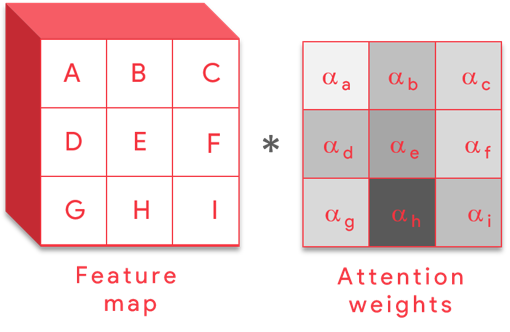

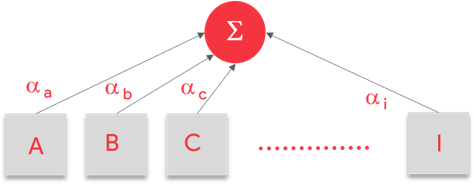

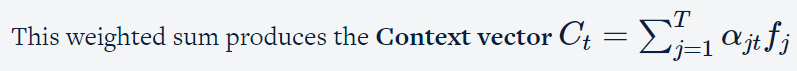

### Decoder

In [106]:
# Creating a class 'Decoder' from the super class 'Model' in 'tensorflow.keras.models':

class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention = Attention_model(self.units) #iniitalise the Attention model with units
        # In the embedding layer, 'vocab_size' is the input dimension and 'embed_dim' is the output dimension:
        self.embed = layers.Embedding(vocab_size, embed_dim, mask_zero = False) #build the Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units) #build the Dense layer
        self.d2 = layers.Dense(vocab_size) #build the Dense layer
        

    def call(self, x, features, hidden):
        # Attention model is placed between the output of the encoder (Feature vector) and hidden state of RNN at that time
        # stamp. This would produce a modified feature vector or the 'context vector', which is much more adaptive (would change
        # as per the previous prediction). Initial set of hidden state, h0 (or the initializer) of RNN is a set of zeros.
        context_vector, attention_weights = self.attention(features, hidden) #create the context vector & attention weights
                                                                             # from attention model
        
        # Embed the input to shape: (batch_size, 1, embedding_dim)
        # Input size = (256, 1) & output size = (256, 1, 256) --> as the batch size = 256 and embedding_dim = 256
        embed =  self.embed(x)
        
        # mask is necessary as the decoder would give importance to the respective token ID's, including the zero values,
        # which were introduced due to padding. If these zeros are not removed while calculating the loss, we would have an
        # added penalty, which must not be considered. Thus, we need mask to mitigate the risk from the added penalty in the
        # loss.
        mask = self.embed.compute_mask(x)
        
        # Concatenate the input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim +
                                                                                     # embedding_dim)
        # Shape of the context_vector from the attention model = (256, 256). We need to reshape it to the same shape
        # as that of the embedding vector: (256, 1, 256). Once both are of the same shape, they can be concatenated easily:
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Shape of the concatenated vector: (256, 1, 512)
        
        # The concatenated vector is fed to the RNN:                                                                         
        output, state = self.gru(embed, mask = mask) # Extract the output & hidden state from GRU layer. Output shape:
                                                 # (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
        # Shape of the hidden layer = (256, 512) --> as the batch size = 256 and units/ number of neurons in GRU = 512
        # Shape of output = (256, 1, 512)
        # This output would then be fed to a dense layer containing 5001 neurons. The final output's shape would be (256, 5001)
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [107]:
# Creating the 'decoder' object with 256 neurons in its dense layer from the class 'Encoder':
decoder = Decoder(embedding_dim, units, vocab_size)

Following is an example image of the summary of the entire process of the caption generation from the image. The batch size that I have taken is 256, whereas this image has been made with batch size = 32. Also, the maximum length of captions is 39, whereas the one shown in this image is of length 40.

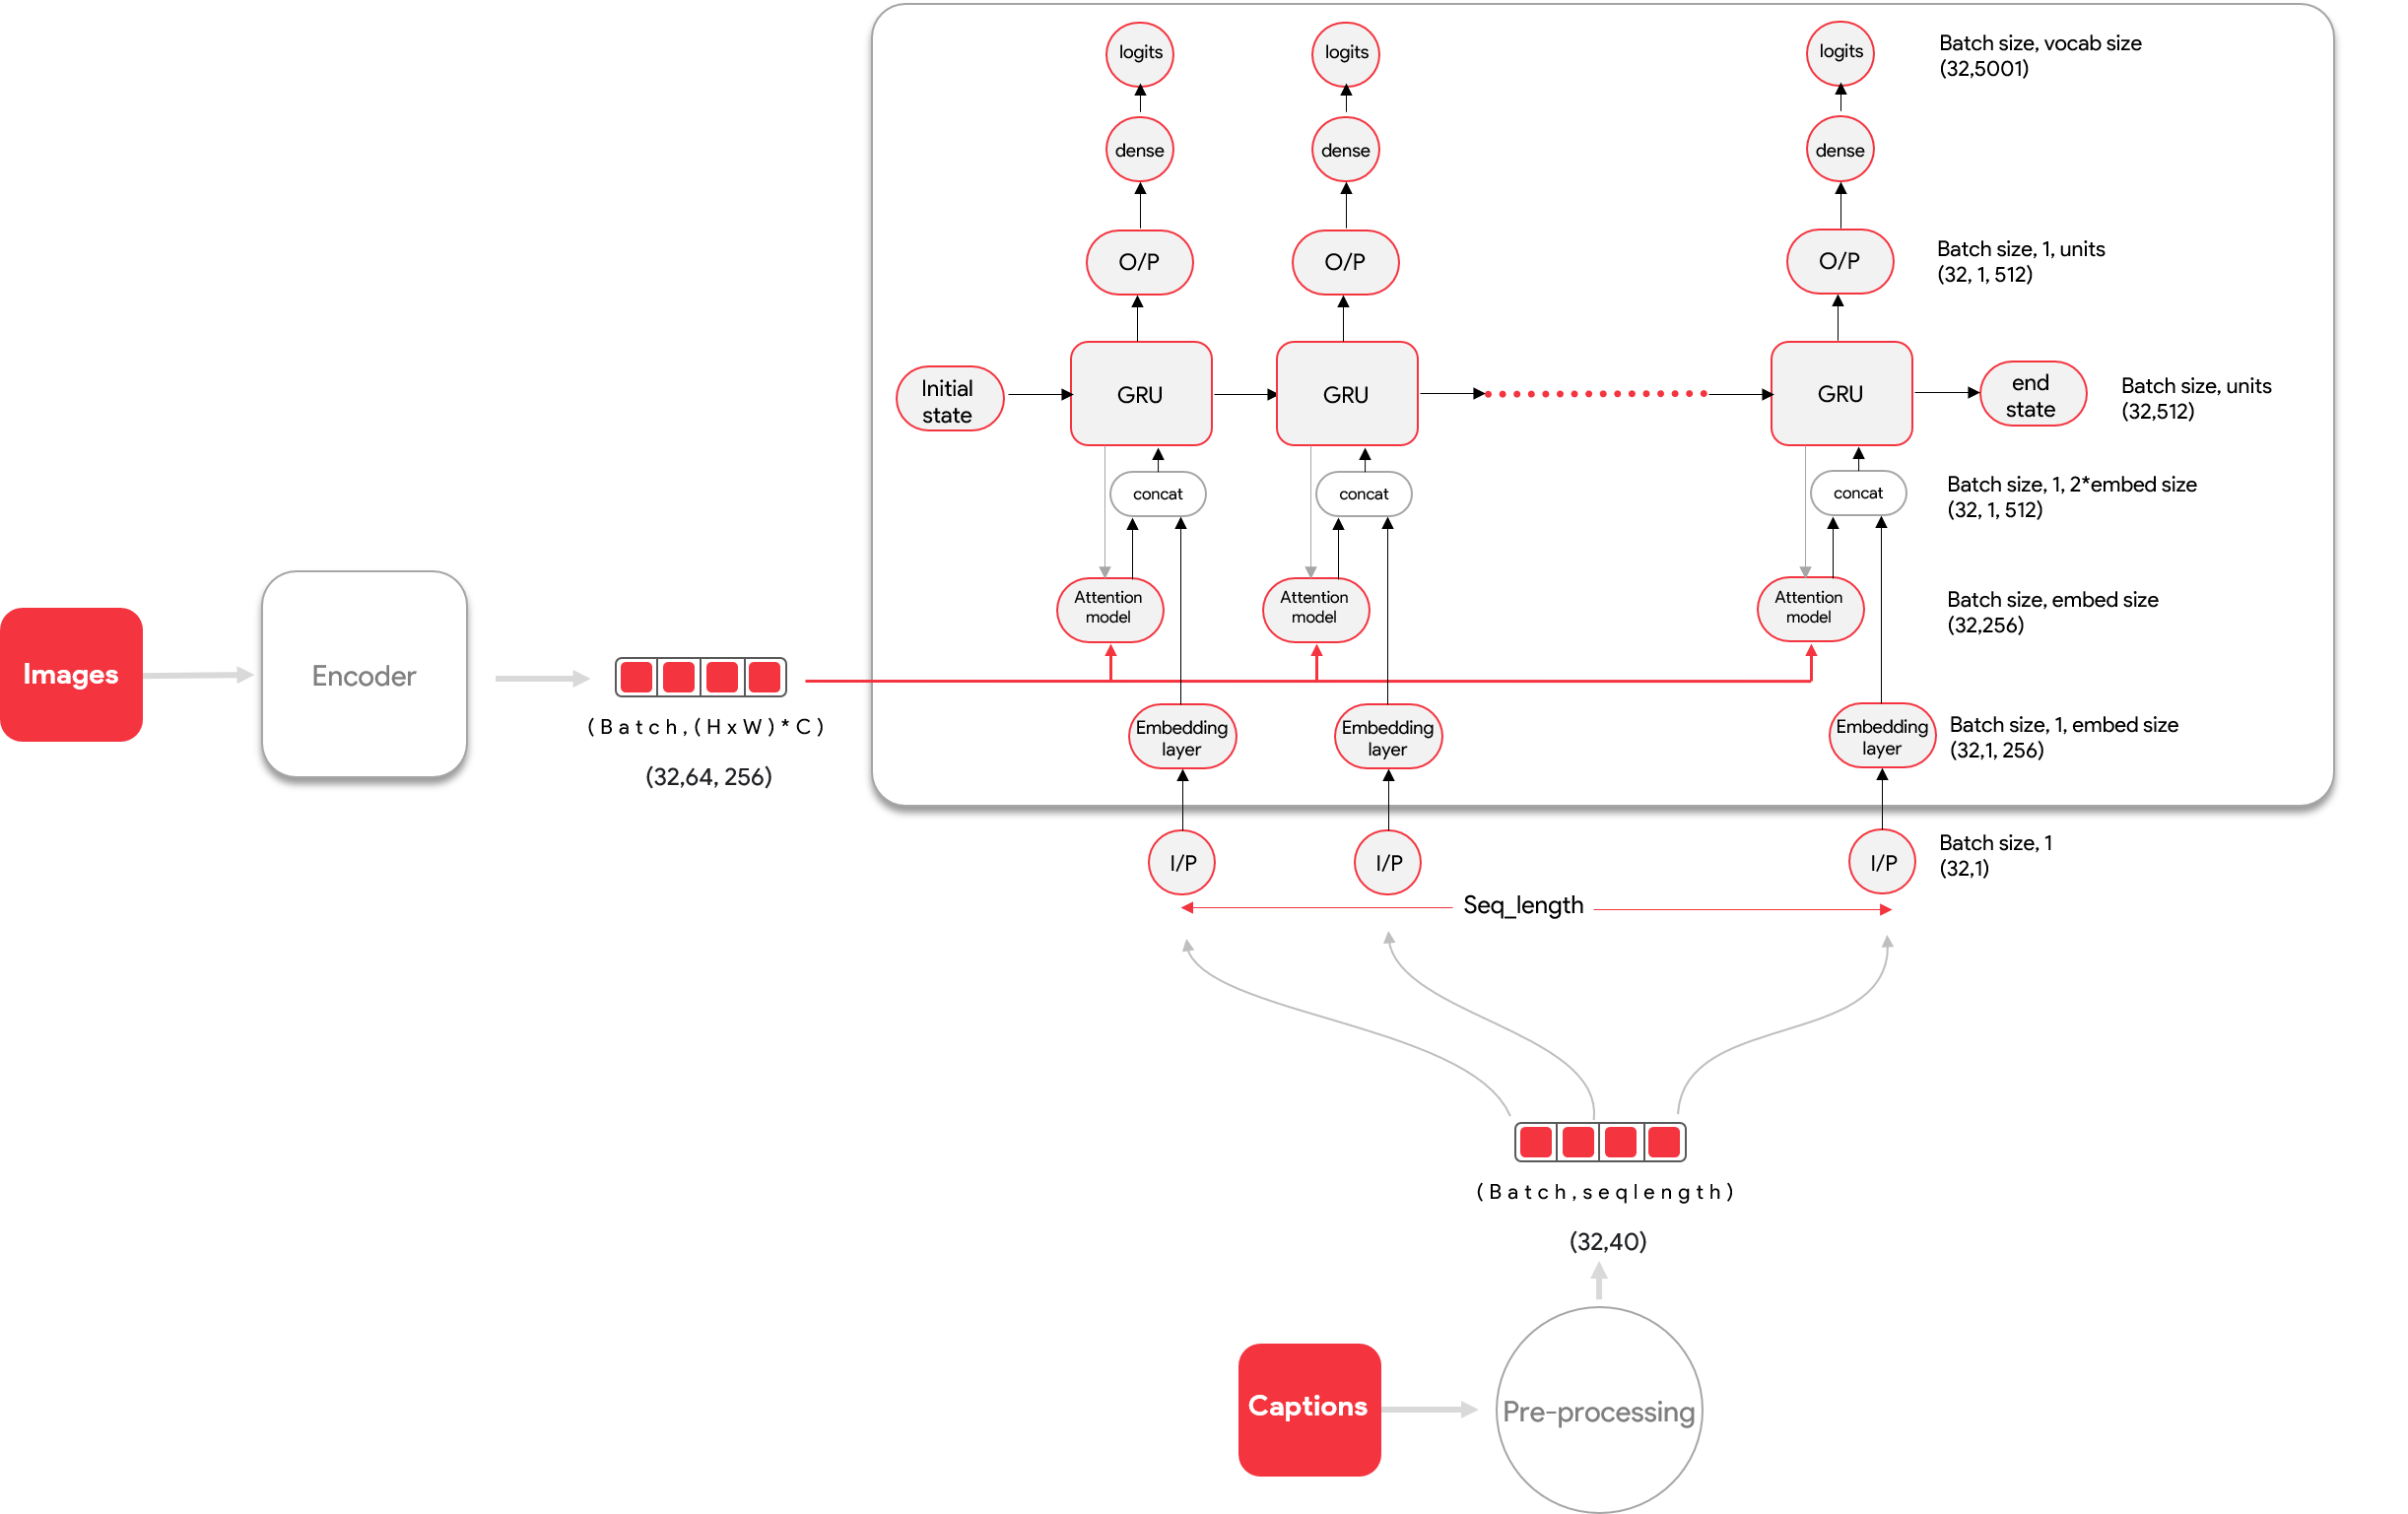!

In [108]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size = sample_cap_batch.shape[0])

# For the first word, RNN (Decoder) would need a prompter. '<start>' token serves as a prompter.
# The <start> token prompts the RNN to predict the first word. It is an input to the RNN and is not found in the output of RNN.
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (256, 64, 256)
Predcitions shape from Decoder: (256, 5001)
Attention weights shape from Decoder: (256, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create checkpoint path

3.Create training & testing step functions

4.Create loss function for the test dataset

In [109]:
# from keras.optimizers import adam_v2
# optimizer = keras.optimizers.adam_v2.Adam(lr = 0.001)

optimizer = tf.keras.optimizers.Adam(lr = 0.001) #define the optimizer

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define the loss object

# 'from_logits = True' signifies the values of the loss obtained by the model are not normalized and is basically used when we
# don't have any softmax function in our model, a.k.a, logits. In other words, the softmax function has not been applied on
# them to produce a probability distribution
# Source: https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy
# -loss-function

# Pushing the "softmax" activation into the cross-entropy loss layer significantly simplifies the loss computation and makes
# it more numerically stable.
# Source: https://stackoverflow.com/questions/57253841/from-logits-true-and-from-logits-false-get-different-training-result-for
# -tf-loss

In [110]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # As explained in the decoder section, mask is necessary to mitigate the risk of the added penalty while calculating the
    # loss. Thus, we need to do: loss = loss * mask. This would truncate all the added penalties back to zeros.
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [111]:
checkpoint_path = "Checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [112]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for the model, I will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [113]:
# Custom Train Step  
@tf.function
def train_step(img_tensor, target) : 

    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)


    with tf.GradientTape() as tape:
        #training steps
        
        # Encoder
        features = encoder(img_tensor, training = True)
        
        # Decoder
        for i in range(1, target.shape[1]) : 
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:,i], predictions)
            # For predicting the first word/ output, RNN (Decoder) needs the <start> token as well as the output of the encoder
            # or, the feature vector. Once the first word has been predicted, it is NOT passed as an input to the RNN (decoder)
            # for the next time stamp. Instead, teacher forcing is applied, wherein, the ground truth word for that time stamp
            # is fed as an input to the RNN (Decoder) for proper training to take place.
            dec_input = tf.expand_dims(target[:,i], 1) # Teacher forcing
    
    # backpropagation
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

* While creating the test step for the model, I will pass the previous prediciton as the next input to the decoder.

In [114]:
# Custom Test Step 

@tf.function
def test_step(img_tensor, target):
    loss = 0

    #testing steps
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1,target.shape[1]) : 
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:,i], predictions)
        
        # Predictions would be a list of prediction score. We would need to take the 'argmax' to take the maximum value:
        predicted_id = tf.argmax(predictions[0])
        # For predicting the first word/ output, RNN (Decoder) needs the <start> token as well as the output of the encoder or,
        # the feature vector. Once the first word has been predicted, it is passed as an input to the RNN (decoder) for the
        # next time stamp.
        # No teacher forcing here, in the test step as we are not training the model here. Instead, we want to test how good
        # our model is.
        dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)


    avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [115]:
def test_loss_cal(test_dataset):
    total_loss = 0

    # Get the average loss result on the test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [116]:
# Code to train and test the model based on the processed data set:

loss_plot = []
test_loss_plot = []
epochs = 50

best_test_loss = 100
for epoch in tqdm(range(0, epochs)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/50 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.560, & test loss is 1.650
Time taken for 1 epoch 103.65087676048279 sec

Test loss has been reduced from 100.000 to 1.650


  4%|▍         | 2/50 [02:20<51:14, 64.05s/it]   

For epoch: 2, the train loss is 1.220, & test loss is 2.011
Time taken for 1 epoch 36.081703186035156 sec



  6%|▌         | 3/50 [02:56<40:09, 51.27s/it]

For epoch: 3, the train loss is 1.075, & test loss is 2.008
Time taken for 1 epoch 36.0635666847229 sec



  8%|▊         | 4/50 [03:32<34:41, 45.26s/it]

For epoch: 4, the train loss is 0.991, & test loss is 2.039
Time taken for 1 epoch 36.039093255996704 sec



 10%|█         | 5/50 [04:08<31:27, 41.95s/it]

For epoch: 5, the train loss is 0.932, & test loss is 1.979
Time taken for 1 epoch 36.094990968704224 sec



 12%|█▏        | 6/50 [04:44<29:19, 39.99s/it]

For epoch: 6, the train loss is 0.886, & test loss is 2.050
Time taken for 1 epoch 36.188013315200806 sec



 14%|█▍        | 7/50 [05:20<27:44, 38.70s/it]

For epoch: 7, the train loss is 0.847, & test loss is 2.030
Time taken for 1 epoch 36.04571485519409 sec



 16%|█▌        | 8/50 [05:56<26:29, 37.85s/it]

For epoch: 8, the train loss is 0.811, & test loss is 2.069
Time taken for 1 epoch 36.019927978515625 sec



 18%|█▊        | 9/50 [06:32<25:28, 37.28s/it]

For epoch: 9, the train loss is 0.780, & test loss is 2.035
Time taken for 1 epoch 36.04072380065918 sec



 20%|██        | 10/50 [07:08<24:36, 36.90s/it]

For epoch: 10, the train loss is 0.751, & test loss is 2.047
Time taken for 1 epoch 36.04743814468384 sec



 22%|██▏       | 11/50 [07:44<23:49, 36.64s/it]

For epoch: 11, the train loss is 0.724, & test loss is 2.082
Time taken for 1 epoch 36.051236152648926 sec



 24%|██▍       | 12/50 [08:20<23:05, 36.46s/it]

For epoch: 12, the train loss is 0.699, & test loss is 2.151
Time taken for 1 epoch 36.03587579727173 sec



 26%|██▌       | 13/50 [08:56<22:26, 36.38s/it]

For epoch: 13, the train loss is 0.675, & test loss is 2.078
Time taken for 1 epoch 36.19610810279846 sec



 28%|██▊       | 14/50 [09:33<21:46, 36.30s/it]

For epoch: 14, the train loss is 0.652, & test loss is 2.082
Time taken for 1 epoch 36.105594873428345 sec



 30%|███       | 15/50 [10:09<21:07, 36.22s/it]

For epoch: 15, the train loss is 0.632, & test loss is 2.174
Time taken for 1 epoch 36.056708574295044 sec



 32%|███▏      | 16/50 [10:45<20:30, 36.20s/it]

For epoch: 16, the train loss is 0.611, & test loss is 2.158
Time taken for 1 epoch 36.15469551086426 sec



 34%|███▍      | 17/50 [11:21<19:54, 36.20s/it]

For epoch: 17, the train loss is 0.591, & test loss is 2.171
Time taken for 1 epoch 36.17777395248413 sec



 36%|███▌      | 18/50 [11:58<19:23, 36.35s/it]

For epoch: 18, the train loss is 0.572, & test loss is 2.223
Time taken for 1 epoch 36.692466497421265 sec



 38%|███▊      | 19/50 [12:34<18:47, 36.38s/it]

For epoch: 19, the train loss is 0.554, & test loss is 2.189
Time taken for 1 epoch 36.45858311653137 sec



 40%|████      | 20/50 [13:10<18:10, 36.34s/it]

For epoch: 20, the train loss is 0.537, & test loss is 2.259
Time taken for 1 epoch 36.263237953186035 sec



 42%|████▏     | 21/50 [13:46<17:31, 36.27s/it]

For epoch: 21, the train loss is 0.521, & test loss is 2.316
Time taken for 1 epoch 36.08622169494629 sec



 44%|████▍     | 22/50 [14:23<16:54, 36.23s/it]

For epoch: 22, the train loss is 0.504, & test loss is 2.378
Time taken for 1 epoch 36.12912678718567 sec



 46%|████▌     | 23/50 [14:59<16:17, 36.19s/it]

For epoch: 23, the train loss is 0.488, & test loss is 2.350
Time taken for 1 epoch 36.09733700752258 sec



 48%|████▊     | 24/50 [15:35<15:40, 36.18s/it]

For epoch: 24, the train loss is 0.474, & test loss is 2.464
Time taken for 1 epoch 36.14902424812317 sec



 50%|█████     | 25/50 [16:11<15:04, 36.17s/it]

For epoch: 25, the train loss is 0.459, & test loss is 2.487
Time taken for 1 epoch 36.16792273521423 sec



 52%|█████▏    | 26/50 [16:47<14:28, 36.17s/it]

For epoch: 26, the train loss is 0.445, & test loss is 2.479
Time taken for 1 epoch 36.172508239746094 sec



 54%|█████▍    | 27/50 [17:23<13:51, 36.17s/it]

For epoch: 27, the train loss is 0.432, & test loss is 2.527
Time taken for 1 epoch 36.168426275253296 sec



 56%|█████▌    | 28/50 [17:59<13:15, 36.15s/it]

For epoch: 28, the train loss is 0.420, & test loss is 2.590
Time taken for 1 epoch 36.09776043891907 sec



 58%|█████▊    | 29/50 [18:36<12:39, 36.15s/it]

For epoch: 29, the train loss is 0.406, & test loss is 2.585
Time taken for 1 epoch 36.14779257774353 sec



 60%|██████    | 30/50 [19:12<12:02, 36.15s/it]

For epoch: 30, the train loss is 0.394, & test loss is 2.665
Time taken for 1 epoch 36.14027500152588 sec



 62%|██████▏   | 31/50 [19:48<11:26, 36.15s/it]

For epoch: 31, the train loss is 0.382, & test loss is 2.773
Time taken for 1 epoch 36.1618390083313 sec



 64%|██████▍   | 32/50 [20:24<10:51, 36.20s/it]

For epoch: 32, the train loss is 0.370, & test loss is 2.746
Time taken for 1 epoch 36.30047845840454 sec



 66%|██████▌   | 33/50 [21:00<10:15, 36.19s/it]

For epoch: 33, the train loss is 0.361, & test loss is 2.897
Time taken for 1 epoch 36.16380548477173 sec



 68%|██████▊   | 34/50 [21:36<09:38, 36.16s/it]

For epoch: 34, the train loss is 0.351, & test loss is 2.752
Time taken for 1 epoch 36.10840106010437 sec



 70%|███████   | 35/50 [22:12<09:02, 36.13s/it]

For epoch: 35, the train loss is 0.341, & test loss is 2.985
Time taken for 1 epoch 36.062474727630615 sec



 72%|███████▏  | 36/50 [22:49<08:25, 36.11s/it]

For epoch: 36, the train loss is 0.331, & test loss is 2.972
Time taken for 1 epoch 36.04604244232178 sec



 74%|███████▍  | 37/50 [23:25<07:49, 36.10s/it]

For epoch: 37, the train loss is 0.320, & test loss is 3.102
Time taken for 1 epoch 36.07731580734253 sec



 76%|███████▌  | 38/50 [24:01<07:13, 36.08s/it]

For epoch: 38, the train loss is 0.317, & test loss is 3.001
Time taken for 1 epoch 36.0493597984314 sec



 78%|███████▊  | 39/50 [24:37<06:36, 36.08s/it]

For epoch: 39, the train loss is 0.309, & test loss is 3.089
Time taken for 1 epoch 36.05723524093628 sec



 80%|████████  | 40/50 [25:13<06:00, 36.08s/it]

For epoch: 40, the train loss is 0.297, & test loss is 3.167
Time taken for 1 epoch 36.09937906265259 sec



 82%|████████▏ | 41/50 [25:49<05:24, 36.07s/it]

For epoch: 41, the train loss is 0.287, & test loss is 3.223
Time taken for 1 epoch 36.04957413673401 sec



 84%|████████▍ | 42/50 [26:25<04:48, 36.07s/it]

For epoch: 42, the train loss is 0.280, & test loss is 3.186
Time taken for 1 epoch 36.0535306930542 sec



 86%|████████▌ | 43/50 [27:01<04:12, 36.07s/it]

For epoch: 43, the train loss is 0.275, & test loss is 3.409
Time taken for 1 epoch 36.066874265670776 sec



 88%|████████▊ | 44/50 [27:37<03:36, 36.06s/it]

For epoch: 44, the train loss is 0.266, & test loss is 3.320
Time taken for 1 epoch 36.04504346847534 sec



 90%|█████████ | 45/50 [28:13<03:00, 36.06s/it]

For epoch: 45, the train loss is 0.259, & test loss is 3.493
Time taken for 1 epoch 36.07045769691467 sec



 92%|█████████▏| 46/50 [28:49<02:24, 36.06s/it]

For epoch: 46, the train loss is 0.254, & test loss is 3.520
Time taken for 1 epoch 36.05965304374695 sec



 94%|█████████▍| 47/50 [29:25<01:48, 36.06s/it]

For epoch: 47, the train loss is 0.250, & test loss is 3.484
Time taken for 1 epoch 36.04703450202942 sec



 96%|█████████▌| 48/50 [30:01<01:12, 36.06s/it]

For epoch: 48, the train loss is 0.244, & test loss is 3.551
Time taken for 1 epoch 36.05985450744629 sec



 98%|█████████▊| 49/50 [30:37<00:36, 36.06s/it]

For epoch: 49, the train loss is 0.238, & test loss is 3.684
Time taken for 1 epoch 36.05583739280701 sec



100%|██████████| 50/50 [31:13<00:00, 37.48s/it]

For epoch: 50, the train loss is 0.234, & test loss is 3.633
Time taken for 1 epoch 36.07086133956909 sec



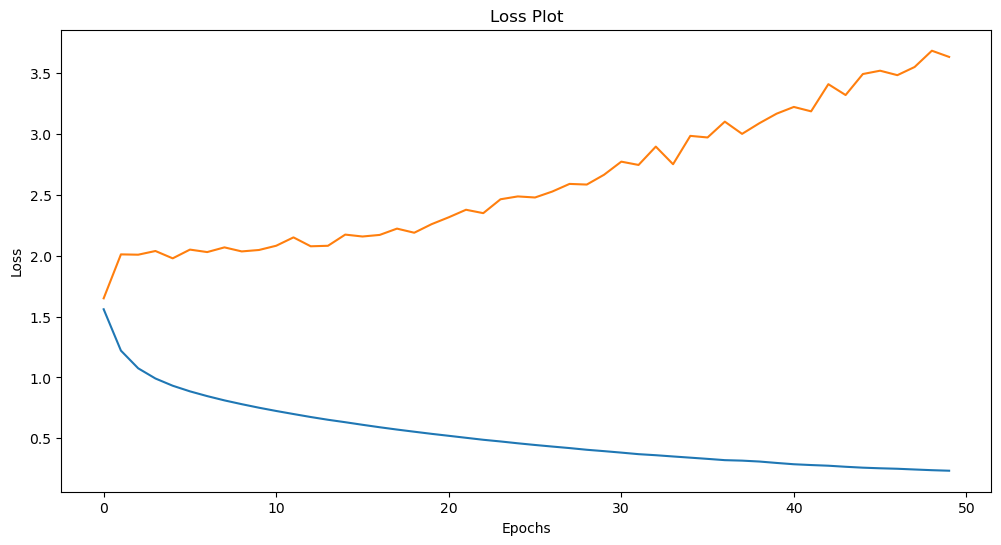

In [117]:
plt.figure(figsize=(12, 6))
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
# plt.legend(loc='best')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), one may observe that the train loss is decreasing while the test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approaches are different.

## Model Evaluation
1.Define the evaluation function using greedy search

2.Define the evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [118]:
def evaluate(image):
    max_length=max_len
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])
        
        # <end> token is required for prompting the RNN (Decoder) to stop the text generation. It is part of the output,
        # unlike the <start> token, which is not the part of the output:
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search

In [119]:
def beam_evaluate(image, beam_index = 3): # Our value for beam index)

    # Code to evaluate the result using beam search
    max_length = max_len
    start = [tokenizer.word_index['<start>']]
    
    # The output of the argmax is saved in a list called 'result'. It would start with the <start> token and keep iterating
    # till it reaches the <end> token. Its initial value is zero:
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i = 0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
                  
    return final_caption

In [120]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(20, 20))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)sn
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [121]:
from nltk.translate.bleu_score import sentence_bleu

In [122]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [123]:
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

BLEU score: 1.0977058971259434e-229
Real Caption: a man holds a trophy on the stage
Prediction Caption: a racer holds up his trophy


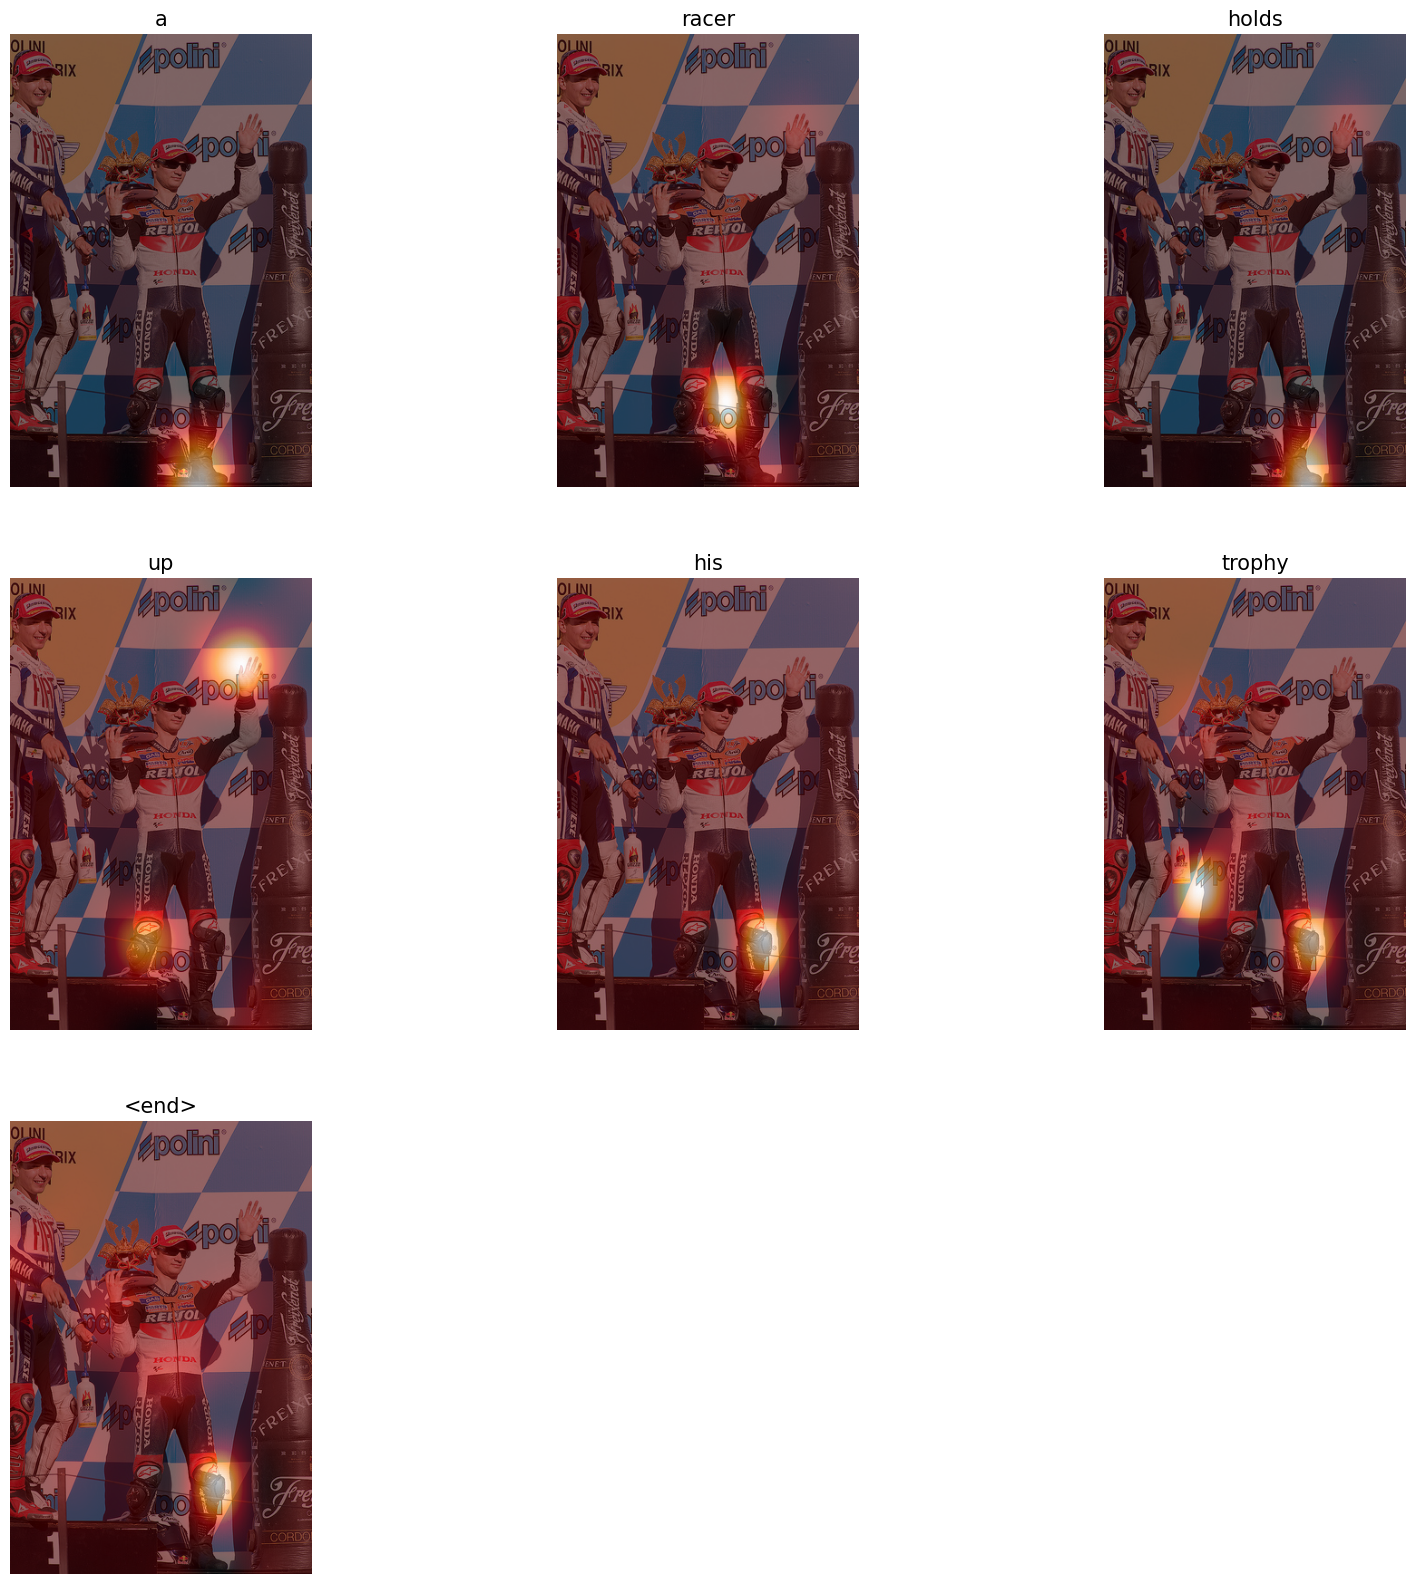

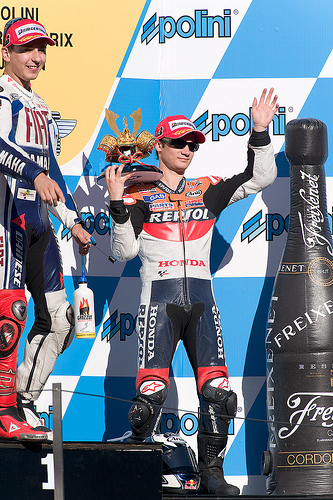

In [124]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
# test_image = 'Images/3446586125_cafa0bfd67.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights= (0.25, 0.25, 0.25, 0.25)) #set the weights # The sum of these weights
                                                                                                 # must be 1 (one)
print(f"BLEU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [125]:
captions=beam_evaluate(test_image)
print(captions)

a racer displaying his trophy and waving


# Converting Text to Speech

In [126]:
# Import the required module for text to speech conversion


# Language in which we want to convert. en is for English:
language = 'en'
  
# Passing the text and language to the engine:
obj = gTTS(text = pred_caption, lang = language, slow = False)
  
# Saving the converted audio in a mp3 file named
obj.save("Predicted_text.mp3")
  
# Playing the converted file
os.system("./Predicted_text.mp3")

audio_file = 'Predicted_text.mp3'

Audio(audio_file, rate='Slow', autoplay=True)

In [2]:
!python PhotoBot.py

Talk
Text: flower painting
Please confirm
yes


C:\Users\Amit\Documents\Academics\NCI\Semester_3\To be submitted\PhotoBot.py:24: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r'C:\\Users\\Amit\\Documents\\Academics\\NCI\\Semester_3\\chromedriver.exe',
C:\Users\Amit\Documents\Academics\NCI\Semester_3\To be submitted\PhotoBot.py:24: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(r'C:\\Users\\Amit\\Documents\\Academics\\NCI\\Semester_3\\chromedriver.exe',
